# Congressional Alpha: Myth or Math?
## 1. Executive Summary

Retail investors pay for platforms like Quiver Quant and Unusual Whales to copy congressional stock trades. Quiver advertises 35% annual returns across all of Congress. TikTok is full of "Pelosi tracker" accounts. The 2020 COVID trading scandal made headlines when senators dumped stocks after a classified pandemic briefing. The narrative writes itself.

I focus on the Senate specifically. Senators sit on fewer, more powerful committees — Finance, Armed Services, Intelligence — and receive classified briefings that give them concentrated access to market-moving information. Prior academic work finds that Senate portfolios outperform House portfolios (Ziobrowski et al., 2004), making the Senate the strongest possible case for congressional alpha. If insider trading exists anywhere in Congress, it should show up here.

I tested it.

Using 6,300 Senate stock trades from 2012-2024, I find senators actually underperform the market by 12% annually. Year-over-year performance correlation is 0.045 – essentially zero – meaning last year's winners tell you nothing about next year's winners. You cannot identify skilled traders in advance. Replication alpha from the filing date is essentially zero, so even if skill existed, you couldn't capture it after disclosure. A "follow last year's top 5 senators" strategy returns -0.6% annually versus 12.1% for buy-and-hold. Senators underperform at every lag tested, from 1 day to 60 days.

What about Quiver's 30% returns? Their backtest starts April 2020 — two weeks after the COVID bottom. In 2020-2021, senator purchases returned +70% and +30% riding the recovery. Since 2022, they've returned +9% annually while the market did +18%. Quiver's own reported alpha is 0.07. The returns come from leverage and lucky timing, not stock-picking skill.

What about the scandal senators? Loeffler made +52% in 2020 selling stocks after the January 24 COVID briefing – but she only traded one year. Perdue, with 1,500+ trades, earned roughly market returns. Inhofe, another COVID scandal name, underperformed by 20%. Tuberville, famous for 130+ disclosure violations, underperformed by 9%. The headline names don't show consistent skill: Loeffler got lucky once, and the others are mediocre to bad.

**The platforms selling congressional trading data are selling noise dressed up as signal; there is no insider nor replication alpha.**

## 2. Literature Review
Early academic work suggested that members of Congress earned abnormal returns in equity markets. Ziobrowski et al. (2004) analyze U.S. Senators’ financial disclosure reports and construct portfolios that mimic reported trades, finding that Senate purchases outperform the market by roughly 1% per month. These findings were widely interpreted as evidence that legislators possess a meaningful informational advantage.

Subsequent research questioned this interpretation. Eggers and Hainmueller (2011) show that earlier results rely heavily on transaction-based portfolio constructions rather than legislators’ actual investment holdings. When individual portfolios are reconstructed and evaluated using modern factor models, they find no evidence of persistent outperformance and, if anything, modest underperformance. This suggests that reported abnormal returns are sensitive to methodological choices.

Most of this literature examines periods prior to the 2012 STOCK Act, which expanded public disclosure requirements for congressional trading. While the Act increased transparency, it remains imperfect: reporting delays of up to 45 days are permitted, penalties for late filings are nominal (typically around $200), enforcement is limited in practice, and disclosures may not fully reflect real-time trading behavior. At the same time, congressional trading remains subject to less stringent oversight than that faced by professional investors and corporate insiders.

This study extends the literature into the post-STOCK-Act period using Senate trades from 2012 to 2024. Consistent with Eggers and Hainmueller (2011), I find that senators underperform the market on average, exhibit no meaningful performance persistence, and generate no economically significant replication alpha after disclosure. These results indicate that, despite imperfect regulation, publicly available congressional trading data contains little exploitable information for investors, and that commercial strategies that copy congressional trades largely reflect noise rather than skill.

## 3. Data and Sample Construction
- **Pre-Step 1**: Loading and cleaning Quiver senate trades
- **Step 1**: Ticker-to-PERMNO mapping (dsenames)
- **Step 2**: Merge trades to CRSP identifiers + dedup
- **Step 3b**: Delisting returns
- **Step 4**: Merge delisting returns into CRSP
- **Steps 5a/b/c**: Forward return computation
- **Step 6**: Direction adjustment (flip sign for sales)
- **Step 7**: Fama–French factors
- **Step 9**: Define holding periods, trading days, senator list

In [1]:
!pip install wrds

In [1]:
import numpy as np
import pandas as pd
import re

sen = pd.read_excel("Congressional Trades.xlsx", sheet_name="Senate")

def parse_trade_size(val):
    if pd.isna(val): return np.nan
    s = str(val).replace(",", "").replace("$", "").strip()
    if "-" in s:
        nums = re.findall(r"\d+", s)
        if len(nums) >= 2:
            low, high = map(float, nums[:2])
            return (low + high) / 2
    nums = re.findall(r"\d+", s)
    return float(nums[0]) if nums else np.nan

sen["Trade_Size_USD"] = sen["Trade_Size_USD"].apply(parse_trade_size)
sen.loc[sen["Trade_Size_USD"] <= 0, "Trade_Size_USD"] = np.nan

sen["Traded"] = pd.to_datetime(sen["Traded"], errors="coerce")
sen["Ticker"] = sen["Ticker"].astype(str).str.strip().str.upper()
sen = sen.dropna(subset=["Traded", "Ticker"])
sen = sen.sort_values("Traded").reset_index(drop=True)
sen["Traded"] = pd.to_datetime(sen["Traded"], errors="coerce")
#sen = sen.set_index("Traded")
print(sen.head(5))

  Ticker TickerType                                      Company     Traded  \
0     DD      Stock  E. I. du Pont de Nemours and Company (NYSE) 2012-09-13   
1     DD      Stock  E. I. du Pont de Nemours and Company (NYSE) 2012-12-17   
2  GMXRQ      Stock             GMX Resources Inc. (OTC Markets) 2013-01-09   
3   AAPL      Stock                          Apple Inc. (NASDAQ) 2013-01-24   
4     DD      Stock  E. I. du Pont de Nemours and Company (NYSE) 2013-03-15   

      Transaction  Trade_Size_USD Status  Subholding Description  \
0        Purchase          8000.5    New         NaN         NaN   
1        Purchase          8000.5    New         NaN         NaN   
2        Purchase          8000.5    New         NaN         NaN   
3  Sale (Partial)          8000.5    New         NaN         NaN   
4        Purchase          8000.5    New         NaN         NaN   

                Name BioGuideID       Filed Party  District Chamber Comments  \
0  Carper, Thomas R.    C000174  201

In [2]:
sen["Transaction"] = sen["Transaction"].astype(str).str.strip().str.title()
sen["Transaction"] = sen["Transaction"].replace({
    "Sale (Partial)": "Sale",
    "Sale (Full)": "Sale",
    "Sold": "Sale",
    "Sell": "Sale",
    "Buy": "Purchase",
    "Purchase (Partial)": "Purchase",
    "Purchase (Full)": "Purchase",
    "Bought": "Purchase"
})

ticker_map = {
    # Major dual-share names
    "BRK.B": "BRKB", "BRK-B": "BRKB", "BRK.A": "BRKA", "BRK-A": "BRKA",
    "LGF.B": "LGFB", "LEN-B": "LENB", "BF.B": "BFB",
    "RDS.A": "RDSA", "RDS.B": "RDSB", "RDS-A": "RDSA", "RDS-B": "RDSB",
    "CWEN.A": "CWENA", "HEI.A": "HEIA",
    "STZ-B": "STZB",

    # Common '1' or suffix variants (same company)
    "WB1": "WB", "DG1": "DG", "TX1": "TX", "SPRI1": "SPRI",
    "FTI1": "FTI", "AGN1": "AGN", "DNB1": "DNB",
    "PDLB1": "PDLB", "ACTV1": "ACTV", "AMH1": "AMH",
    "UNTD1": "UNTD", "USBC1": "USBC",
}

sen["Ticker"] = sen["Ticker"].replace(ticker_map)

# Drop junk tickers: preferreds, warrants, funds, delisted issues 
drop_pattern = r"(WD|PL|PA|PB|PC|PD|PE|PF|PG|PH|PI|PR|W|LP|FUNDS|TEST|U$|\d{3,}|MI$|WS$)"
sen = sen[~sen["Ticker"].str.contains(drop_pattern, regex=True)]

# Drop empty or malformed tickers (e.g., digits-only)
sen = sen[sen["Ticker"].str.fullmatch(r"[A-Z]{1,5}")]

bad_tickers = sen[sen["Ticker"].str.contains(r"[^A-Z]", regex=True)]["Ticker"].value_counts()
print(bad_tickers.head(30))
print(len(bad_tickers))
print("Unique tickers:", sen["Ticker"].nunique())
print("Total transactions:", len(sen))


print("Trade date range:", sen["Traded"].min(), "→", sen["Traded"].max())
print(sen[["Traded", "Ticker", "Transaction", "Trade_Size_USD"]].head(10))

Series([], Name: count, dtype: int64)
0
Unique tickers: 1323
Total transactions: 9070
Trade date range: 2012-09-13 00:00:00 → 2025-09-24 00:00:00
       Traded Ticker Transaction  Trade_Size_USD
0  2012-09-13     DD    Purchase          8000.5
1  2012-12-17     DD    Purchase          8000.5
2  2013-01-09  GMXRQ    Purchase          8000.5
4  2013-03-15     DD    Purchase          8000.5
5  2013-04-29     CG    Purchase        175000.5
6  2013-05-01    KMP    Exchange         32500.5
7  2013-05-24    TRN    Purchase         32500.5
8  2013-06-06    TRN    Purchase          8000.5
9  2013-06-13     DD    Purchase          8000.5
10 2013-06-17    ARP    Purchase         32500.5


/var/folders/x6/b1qbwnr93vxd3xn9ntvk7fpc0000gn/T/ipykernel_7061/1831991948.py:32: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sen = sen[~sen["Ticker"].str.contains(drop_pattern, regex=True)]


In [3]:
import wrds
conn = wrds.Connection()

Enter your WRDS username [ilya]: ilya2121
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
# Step 1: Pull ticker-PERMNO mapping table
dsenames = conn.raw_sql("""
    SELECT permno, ticker, cusip, namedt, nameendt, shrcd, exchcd
    FROM crsp.dsenames
""")

dsenames['ticker'] = dsenames['ticker'].astype(str).str.strip().str.upper()
dsenames['namedt'] = pd.to_datetime(dsenames['namedt'])
dsenames['nameendt'] = pd.to_datetime(dsenames['nameendt'])

print(f"dsenames rows: {len(dsenames)}")

# Step 2: Match senate trades to PERMNO using ticker + date range
merged = sen.merge(dsenames, left_on='Ticker', right_on='ticker', how='left')
merged = merged[
    (merged['Traded'] >= merged['namedt']) & 
    (merged['Traded'] <= merged['nameendt'])
]

# Filter to common stocks only
merged = merged[merged['shrcd'].isin([10, 11])]

# Remove duplicates: same trade can match multiple PERMNOs (ticker changes, CUSIP changes)
# Keep one row per unique trade (Ticker, Traded, senator, Transaction type)
merged = merged.drop_duplicates(subset=['Ticker', 'Traded', 'BioGuideID', 'Transaction'], keep='first')

print(f"Matched trades: {len(merged)}")
print(f"Unique PERMNOs: {merged['permno'].nunique()}")

dsenames rows: 117859
Matched trades: 5911
Unique PERMNOs: 761


In [5]:
matched_permnos = merged['permno'].dropna().unique().astype(int)
permno_str = ', '.join(map(str, matched_permnos))

crsp = conn.raw_sql(f"""
    SELECT permno, date, ret, prc, shrout
    FROM crsp.dsf
    WHERE date BETWEEN '2012-01-01' AND '2025-12-31'
    AND permno IN ({permno_str})
""")

print(f"CRSP rows: {len(crsp)}")
print(f"Unique PERMNOs: {crsp['permno'].nunique()}")

CRSP rows: 2081737
Unique PERMNOs: 761


In [6]:
# Step 3b: Pull delisting returns
delist = conn.raw_sql(f"""
    SELECT permno, dlstdt as date, dlret
    FROM crsp.dsedelist
    WHERE permno IN ({permno_str})
""")

print(f"Delisting events: {len(delist)}")

Delisting events: 761


In [13]:
print(delist.head(10))
print(f"\nDate range: {delist['date'].min()} to {delist['date'].max()}")

   permno        date     dlret
0   10026  2024-12-31      <NA>
1   10104  2024-12-31      <NA>
2   10107  2024-12-31      <NA>
3   10145  2024-12-31      <NA>
4   10147  2016-09-06  0.012051
5   10180  2020-05-29 -0.166667
6   10299  2017-03-10  0.003209
7   10302  2020-04-15  0.001259
8   10516  2024-12-31      <NA>
9   10517  2024-12-31      <NA>

Date range: 2014-05-06 to 2024-12-31


In [7]:
# Step 4: Merge delisting returns into CRSP
crsp['date'] = pd.to_datetime(crsp['date'])
delist['date'] = pd.to_datetime(delist['date'])

crsp = crsp.merge(delist, on=['permno', 'date'], how='left')

crsp['ret'] = pd.to_numeric(crsp['ret'], errors='coerce')
crsp['dlret'] = pd.to_numeric(crsp['dlret'], errors='coerce')

# Compound delisting return with regular return
crsp['ret_adj'] = np.where(
    crsp['dlret'].notna(),
    (1 + crsp['ret'].fillna(0)) * (1 + crsp['dlret']) - 1,
    crsp['ret']
)

print(f"Actual delistings captured: {crsp['dlret'].notna().sum()}")
print(crsp[crsp['dlret'].notna()].head())

Actual delistings captured: 187
       permno       date       ret    prc     shrout     dlret   ret_adj
14256   10147 2016-09-06  0.009732  29.05  1956842.0  0.012051  0.021900
16371   10180 2020-05-29 -0.510071   0.09   126246.0 -0.166667 -0.591726
17676   10299 2017-03-10 -0.004137   65.0   240439.0  0.003209 -0.000941
19760   10302 2020-04-15       0.0  23.82   373644.0  0.001259  0.001259
35465   10909 2022-06-07 -0.000527  94.92   294098.0  0.000843  0.000316


In [8]:
# Step 5a: Create lookup structure for fast return calculation
crsp_sorted = crsp.sort_values(['permno', 'date']).reset_index(drop=True)

# Create dictionaries for fast lookup
date_lookup = crsp_sorted.groupby('permno')['date'].apply(list).to_dict()
ret_lookup = crsp_sorted.groupby('permno')['ret_adj'].apply(list).to_dict()

print(f"Built lookup for {len(date_lookup)} PERMNOs")

Built lookup for 761 PERMNOs


In [9]:
# Step 5b: Function to get forward returns
def get_forward_return(row, holding_days=21):
    permno = row['permno']
    trade_date = row['Traded']
    
    if permno not in date_lookup:
        return np.nan
    
    dates = date_lookup[permno]
    rets = ret_lookup[permno]
    
    # Find first date AFTER trade (t+1, avoids look-ahead bias)
    start_idx = None
    for i, d in enumerate(dates):
        if d > trade_date:
            start_idx = i
            break
    
    if start_idx is None:
        return np.nan
    
    end_idx = min(start_idx + holding_days, len(rets))
    period_rets = rets[start_idx:end_idx]
    
    if len(period_rets) == 0:
        return np.nan
    
    cum_ret = np.prod([1 + r for r in period_rets if not np.isnan(r)]) - 1
    return cum_ret

# Test on one row
print(get_forward_return(merged.iloc[0], 21))

-0.047721633387279416


In [10]:
# Step 5c: Calculate forward returns for all trades
merged['ret_21d'] = merged.apply(lambda x: get_forward_return(x, 21), axis=1)

print(f"Done. Trades with 21d returns: {merged['ret_21d'].notna().sum()}")
print(f"Mean 21d return: {merged['ret_21d'].mean():.4f}")

Done. Trades with 21d returns: 5909
Mean 21d return: 0.0096


In [11]:
# Step 6: Adjust for transaction direction
# For sales, a NEGATIVE return after selling = good call (you avoided loss)
# So flip the sign for sales

merged['ret_21d_adj'] = np.where(
    merged['Transaction'] == 'Sale',
    -merged['ret_21d'],  # flip sign for sales
    merged['ret_21d']    # keep as-is for purchases
)

print("By transaction type:")
print(merged.groupby('Transaction')['ret_21d'].agg(['count', 'mean']).round(4))

print("\nAfter sign adjustment:")
print(f"Mean adjusted return: {merged['ret_21d_adj'].mean():.4f}")

By transaction type:
             count    mean
Transaction               
Exchange        21  0.0173
Purchase      2868  0.0113
Sale          3020  0.0079

After sign adjustment:
Mean adjusted return: 0.0015


In [12]:
# Step 7: Get Fama-French factors
conn = wrds.Connection()

ff = conn.raw_sql("""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.fivefactors_daily
    WHERE date BETWEEN '2012-01-01' AND '2024-12-31'
""")
conn.close()

ff['date'] = pd.to_datetime(ff['date'])
print(f"FF rows: {len(ff)}")
print(ff.head())

Enter your WRDS username [ilya]: ilya2121
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
FF rows: 3270
        date   mktrf     smb     hml   rf
0 2012-01-03   0.015 -0.0012   0.009  0.0
1 2012-01-04     0.0 -0.0061  0.0001  0.0
2 2012-01-05  0.0039  0.0019  0.0018  0.0
3 2012-01-06 -0.0019 -0.0003  -0.003  0.0
4 2012-01-09  0.0028  0.0026 -0.0007  0.0


In [13]:
# Step 9: Define holding period and build positions
HOLDING_PERIODS = {
    '1w': 5,
    '1m': 21,
    '3m': 63,
    '6m': 126
}

# Get all trading days from CRSP
trading_days = crsp['date'].sort_values().unique()

# Get unique senators by BioGuideID
senators = merged['BioGuideID'].unique()
print(f"Unique senators: {len(senators)}")

# Preview one senator's trades
test_senator = senators[0]
print(f"\nExample: {test_senator}")
print(merged[merged['BioGuideID'] == test_senator][['Traded', 'Ticker', 'Transaction', 'permno', 'Name']].head(10))

Unique senators: 51

Example: C000174
         Traded Ticker Transaction  permno               Name
4    2012-09-13     DD    Purchase   11703  Carper, Thomas R.
12   2012-12-17     DD    Purchase   11703  Carper, Thomas R.
21   2013-03-15     DD    Purchase   11703  Carper, Thomas R.
63   2013-06-13     DD    Purchase   11703  Carper, Thomas R.
78   2013-09-13     DD    Purchase   11703  Carper, Thomas R.
124  2013-12-16     DD    Purchase   11703  Carper, Thomas R.
3991 2014-03-14     DD    Purchase   11703  Carper, Thomas R.
4258 2014-04-02   ATML    Purchase   76584  Carper, Thomas R.
4317 2014-04-03    BHI        Sale   75034  Carper, Thomas R.
7606 2014-05-30    OKE        Sale   25232  Carper, Thomas R.


## 4. Insider Alpha: Calendar-Time Portfolios

We construct daily calendar-time portfolios for each senator and test whether they earn abnormal returns (alpha) after controlling for Fama–French factors. Portfolios are built under both equal-weighted and value-weighted (by trade size) schemes.
- **Step 10 (portfolio construction):** For each senator, we build a daily portfolio of positions entered in the past *N* trading days. On each trading day, we compute the equal-weighted or value-weighted return of all active positions, flipping the sign for sales.
- **Step 11 (one-senator test):** We run a Fama–French 3-factor regression (Mkt-RF, SMB, HML) on one senator's portfolio as a pipeline check, under both equal-weighted and value-weighted schemes. The intercept (alpha) measures abnormal return after controlling for market, size, and value exposures.
- **Step 12 (all senators):** We repeat the FF regression for all senators with at least 30 portfolio-days. For each senator, we record daily alpha, annualized alpha, t-statistic, p-value, market beta, and R-squared—under both equal-weighted and value-weighted.
- **Summary stats:** We report the cross-sectional distribution of annualized alpha (mean, median, quartiles), list senators with individually significant alphas (p < 0.05), and count how many have positive vs negative alpha.
- **Step 13 (mean alpha test):** We test whether the average senator alpha is significantly different from zero using a one-sample t-test, and apply Bonferroni correction for multiple testing.
- **Step 14 (multiple holding periods):** We repeat the full analysis across four holding periods (1 week, 1 month, 3 months, 6 months) under both equal-weighted and value-weighted, to check whether the conclusion depends on the choice of horizon.

In [14]:
# Step 10: Build calendar-time portfolio for one senator
def build_senator_portfolio(bio_id, holding_days=21, value_weighted=False):
    """
    For each trading day, calculate portfolio return based on 
    positions entered in the past holding_days.
    value_weighted: if True, weight each position by Trade_Size_USD.
    """
    sen_trades = merged[merged['BioGuideID'] == bio_id].copy()
    sen_trades = sen_trades.sort_values('Traded')
    
    # Get date range for this senator
    first_trade = sen_trades['Traded'].min()
    last_trade = sen_trades['Traded'].max()
    
    # Trading days in their active period
    active_days = trading_days[(trading_days >= first_trade) & 
                               (trading_days <= last_trade + pd.Timedelta(days=holding_days*2))]
    
    portfolio_returns = []
    
    for day in active_days:
        day_ts = pd.Timestamp(day)
        
        # Find trades still in holding period (strict: past holding_days trading days only)
        idx = np.searchsorted(trading_days, day_ts, side='right') - 1
        if idx < holding_days:
            continue
        lookback_start = trading_days[idx - holding_days]
        recent_trades = sen_trades[
            (sen_trades['Traded'] >= lookback_start) & 
            (sen_trades['Traded'] < day_ts)
        ]
        
        if len(recent_trades) == 0:
            continue
        
        # Get today's returns for held positions
        day_returns = []
        day_weights = []
        for _, trade in recent_trades.iterrows():
            permno = trade['permno']
            ret_today = crsp[(crsp['permno'] == permno) & (crsp['date'] == day_ts)]['ret_adj']
            
            if len(ret_today) > 0 and pd.notna(ret_today.values[0]):
                # Flip sign for sales
                r = ret_today.values[0]
                if trade['Transaction'] == 'Sale':
                    r = -r
                day_returns.append(r)
                # Weight by trade size for value-weighted; use 1.0 if missing
                w = trade.get('Trade_Size_USD')
                day_weights.append(w if pd.notna(w) and w > 0 else 1.0)
        
        if len(day_returns) > 0:
            if value_weighted:
                weights = np.array(day_weights, dtype=float)
                weights = weights / weights.sum()
                port_ret = np.sum(np.array(day_returns) * weights)
            else:
                port_ret = np.mean(day_returns)
            portfolio_returns.append({'date': day_ts, 'port_ret': port_ret, 'n_positions': len(day_returns)})
    
    return pd.DataFrame(portfolio_returns)

# Test on one senator
test_portfolio = build_senator_portfolio(test_senator, holding_days=21)
print(f"Portfolio days: {len(test_portfolio)}")
print(test_portfolio.head(10))

Portfolio days: 1224
        date  port_ret  n_positions
0 2012-09-14  0.021709            1
1 2012-09-17 -0.010528            1
2 2012-09-18 -0.008125            1
3 2012-09-19  0.006827            1
4 2012-09-20  0.004843            1
5 2012-09-21 -0.001350            1
6 2012-09-24 -0.011776            1
7 2012-09-25 -0.014456            1
8 2012-09-26  0.000991            1
9 2012-09-27  0.006733            1


In [64]:
# Step 11: Run FF regression for one senator (equal-weighted and value-weighted)
import statsmodels.api as sm

def run_ff_for_portfolio(port_df, label):
    """Run FF regression on a portfolio dataframe and print results with label."""
    reg = port_df.merge(ff, on='date', how='inner')
    reg['excess_ret'] = reg['port_ret'] - reg['rf']
    for col in ['mktrf', 'smb', 'hml', 'rf', 'excess_ret']:
        reg[col] = reg[col].astype(float)
    X = sm.add_constant(reg[['mktrf', 'smb', 'hml']])
    y = reg['excess_ret']
    model = sm.OLS(y, X).fit()
    daily_alpha = model.params['const']
    annual_alpha = daily_alpha * 252
    print(f"\n{label}")
    print("-" * len(label))
    print(model.summary())
    print(f"Daily alpha: {daily_alpha:.6f}")
    print(f"Annualized alpha: {annual_alpha:.4f} ({annual_alpha*100:.2f}%)")
    print(f"Alpha t-stat: {model.tvalues['const']:.2f}")
    return model

# --- EQUAL-WEIGHTED ---
run_ff_for_portfolio(test_portfolio, "EQUAL-WEIGHTED (one senator)")

# --- VALUE-WEIGHTED ---
test_portfolio_vw = build_senator_portfolio(test_senator, holding_days=21, value_weighted=True)
run_ff_for_portfolio(test_portfolio_vw, "VALUE-WEIGHTED (one senator)")


EQUAL-WEIGHTED (one senator)
----------------------------
                            OLS Regression Results                            
Dep. Variable:             excess_ret   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     7.457
Date:                Sat, 07 Feb 2026   Prob (F-statistic):           5.99e-05
Time:                        13:25:46   Log-Likelihood:                 3410.1
No. Observations:                1224   AIC:                            -6812.
Df Residuals:                    1220   BIC:                            -6792.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [16]:
# Step 12: Run FF regression for all senators (equal-weighted and value-weighted)

def run_ff_all_senators(value_weighted=False):
    results = []
    for bio_id in senators:
        port = build_senator_portfolio(bio_id, holding_days=21, value_weighted=value_weighted)
        if len(port) < 30:
            continue
        reg_data = port.merge(ff, on='date', how='inner')
        if len(reg_data) < 30:
            continue
        reg_data['excess_ret'] = reg_data['port_ret'] - reg_data['rf']
        for col in ['mktrf', 'smb', 'hml', 'rf', 'excess_ret']:
            reg_data[col] = reg_data[col].astype(float)
        X = sm.add_constant(reg_data[['mktrf', 'smb', 'hml']])
        y = reg_data['excess_ret']
        try:
            model = sm.OLS(y, X).fit()
            name = merged[merged['BioGuideID'] == bio_id]['Name'].iloc[0]
            results.append({
                'BioGuideID': bio_id,
                'Name': name,
                'n_days': len(reg_data),
                'daily_alpha': model.params['const'],
                'annual_alpha': model.params['const'] * 252,
                'alpha_tstat': model.tvalues['const'],
                'alpha_pval': model.pvalues['const'],
                'mkt_beta': model.params['mktrf'],
                'r_squared': model.rsquared
            })
        except:
            continue
    return pd.DataFrame(results)

# --- EQUAL-WEIGHTED ---
results_df = run_ff_all_senators(value_weighted=False)
print("EQUAL-WEIGHTED (all senators)")
print("-" * 35)
print(f"Senators with results: {len(results_df)}")
print(results_df.sort_values('annual_alpha', ascending=False).head(10))

# --- VALUE-WEIGHTED ---
results_df_vw = run_ff_all_senators(value_weighted=True)
print("\nVALUE-WEIGHTED (all senators)")
print("-" * 35)
print(f"Senators with results: {len(results_df_vw)}")
print(results_df_vw.sort_values('annual_alpha', ascending=False).head(10))

EQUAL-WEIGHTED (all senators)
-----------------------------------
Senators with results: 40
   BioGuideID             Name  n_days  daily_alpha  annual_alpha  \
31    R000608     Rosen, Jacky      89     0.004574      1.152666   
26    C001088     Coons, Chris     105     0.003329      0.838896   
14    T000476     Tillis, Thom      63     0.003258      0.821117   
36    H000601    Hagerty, Bill     155     0.001167      0.294167   
33    L000594  Loeffler, Kelly     146     0.001157      0.291648   
29    K000352         Kyl, Jon      59     0.000930      0.234285   
10    K000383      King, Angus     415     0.000680      0.171408   
5     H001061     Hoeven, John     860     0.000371      0.093518   
34    W000779       Wyden, Ron     291     0.000294      0.074107   
30    M000934     Moran, Jerry     172     0.000272      0.068627   

    alpha_tstat  alpha_pval  mkt_beta  r_squared  
31     2.864537    0.005260  0.736121   0.285865  
26     1.639334    0.104255 -1.611418   0.4458

In [19]:
# Summary stats (equal-weighted and value-weighted)

def summarize_alpha_results(df, label):
    print(f"\n{label}")
    print("-" * len(label))
    print("Alpha distribution:")
    print(df['annual_alpha'].describe())
    print("\nSignificant alphas (p < 0.05):")
    print(df[df['alpha_pval'] < 0.05][['Name', 'annual_alpha', 'alpha_tstat', 'alpha_pval', 'n_days']])
    print("\nBottom 10 (worst performers):")
    print(df.sort_values('annual_alpha').head(10)[['Name', 'annual_alpha', 'alpha_tstat', 'n_days']])
    print(f"\nPositive alpha: {(df['annual_alpha'] > 0).sum()}")
    print(f"Negative alpha: {(df['annual_alpha'] < 0).sum()}")

# --- EQUAL-WEIGHTED ---
summarize_alpha_results(results_df, "EQUAL-WEIGHTED")

# --- VALUE-WEIGHTED ---
summarize_alpha_results(results_df_vw, "VALUE-WEIGHTED")


EQUAL-WEIGHTED
--------------
Alpha distribution:
count    40.000000
mean     -0.102242
std       0.471815
min      -1.399390
25%      -0.229328
50%      -0.069833
75%       0.067628
max       1.152666
Name: annual_alpha, dtype: float64

Significant alphas (p < 0.05):
             Name  annual_alpha  alpha_tstat  alpha_pval  n_days
12    Toomey, Pat     -0.630261    -2.101930    0.036023     543
19      Cruz, Ted     -1.399390    -3.511875    0.000735      84
27  Sullivan, Dan     -0.484684    -2.215922    0.027283     388
31   Rosen, Jacky      1.152666     2.864537    0.005260      89
39  Boozman, John     -0.939531    -2.829219    0.005425     131

Bottom 10 (worst performers):
                          Name  annual_alpha  alpha_tstat  n_days
19                   Cruz, Ted     -1.399390    -3.511875      84
32  McConnell, A. Mitchell Jr.     -1.004892    -1.741603      42
39               Boozman, John     -0.939531    -2.829219     131
11                  Blunt, Roy     -0.864091 

In [20]:
# Step 13: Test if mean alpha is significantly different from zero (equal-weighted and value-weighted)
from scipy import stats

def test_mean_alpha(df, label):
    t_stat, p_val = stats.ttest_1samp(df['annual_alpha'], 0)
    print(f"\n{label}")
    print("-" * len(label))
    print(f"Mean alpha: {df['annual_alpha'].mean():.4f}")
    print(f"t-stat: {t_stat:.2f}, p-value: {p_val:.4f}")
    n_tests = len(df)
    bonferroni_threshold = 0.05 / n_tests
    print(f"Bonferroni threshold: {bonferroni_threshold:.4f}")
    print("Significant after Bonferroni:")
    sig = df[df['alpha_pval'] < bonferroni_threshold][['Name', 'annual_alpha', 'alpha_pval']]
    print(sig if len(sig) > 0 else "(none)")

# --- EQUAL-WEIGHTED ---
test_mean_alpha(results_df, "EQUAL-WEIGHTED")

# --- VALUE-WEIGHTED ---
test_mean_alpha(results_df_vw, "VALUE-WEIGHTED")


EQUAL-WEIGHTED
--------------
Mean alpha: -0.1022
t-stat: -1.37, p-value: 0.1784
Bonferroni threshold: 0.0013
Significant after Bonferroni:
         Name  annual_alpha  alpha_pval
19  Cruz, Ted      -1.39939    0.000735

VALUE-WEIGHTED
--------------
Mean alpha: -0.1266
t-stat: -1.72, p-value: 0.0937
Bonferroni threshold: 0.0013
Significant after Bonferroni:
(none)


 Equal-weighted mean alpha is −10.2% (t = −1.37, p = 0.18); value-weighted is −12.7% (t = −1.72, p = 0.09). Neither is significant at 5%. After Bonferroni, only Cruz (negative alpha) is significant under equal-weighting; under value-weighting, none are. 
 
No evidence that senators’ average alpha differs from zero; value-weighting does not change this.

In [21]:
# Step 14: Test multiple holding periods (equal-weighted and value-weighted)
HOLDING_PERIODS = {'1w': 5, '1m': 21, '3m': 63, '6m': 126}

def run_multi_period(value_weighted=False):
    out = {}
    for period_name, holding_days in HOLDING_PERIODS.items():
        results = []
        for bio_id in senators:
            port = build_senator_portfolio(bio_id, holding_days=holding_days, value_weighted=value_weighted)
            if len(port) < 30:
                continue
            reg_data = port.merge(ff, on='date', how='inner')
            if len(reg_data) < 30:
                continue
            reg_data['excess_ret'] = reg_data['port_ret'] - reg_data['rf']
            for col in ['mktrf', 'smb', 'hml', 'rf', 'excess_ret']:
                reg_data[col] = reg_data[col].astype(float)
            try:
                X = sm.add_constant(reg_data[['mktrf', 'smb', 'hml']])
                y = reg_data['excess_ret']
                model = sm.OLS(y, X).fit()
                name = merged[merged['BioGuideID'] == bio_id]['Name'].iloc[0]
                results.append({
                    'BioGuideID': bio_id, 'Name': name, 'n_days': len(reg_data),
                    'annual_alpha': model.params['const'] * 252,
                    'alpha_tstat': model.tvalues['const'], 'alpha_pval': model.pvalues['const']
                })
            except:
                continue
        out[period_name] = pd.DataFrame(results)
    return out

def print_period_summary(all_res, label):
    print(f"\n{label}")
    print("=" * len(label))
    for period_name, results_df in all_res.items():
        if len(results_df) == 0:
            continue
        holding_days = HOLDING_PERIODS[period_name]
        print(f"\n{period_name} ({holding_days} days):")
        t_stat, p_val = stats.ttest_1samp(results_df['annual_alpha'], 0)
        print(f"  Senators: {len(results_df)}, Mean alpha: {results_df['annual_alpha'].mean():.2%}, t-stat: {t_stat:.2f}, p-value: {p_val:.4f}")
        print(f"  Positive/Negative: {(results_df['annual_alpha']>0).sum()}/{(results_df['annual_alpha']<0).sum()}, Significant (p<0.05): {(results_df['alpha_pval']<0.05).sum()}")

# --- EQUAL-WEIGHTED ---
all_results = run_multi_period(value_weighted=False)
print_period_summary(all_results, "EQUAL-WEIGHTED")

# --- VALUE-WEIGHTED ---
all_results_vw = run_multi_period(value_weighted=True)
print_period_summary(all_results_vw, "VALUE-WEIGHTED")


EQUAL-WEIGHTED

1w (5 days):
  Senators: 29, Mean alpha: -16.00%, t-stat: -1.85, p-value: 0.0749
  Positive/Negative: 10/19, Significant (p<0.05): 1

1m (21 days):
  Senators: 40, Mean alpha: -10.22%, t-stat: -1.37, p-value: 0.1784
  Positive/Negative: 16/24, Significant (p<0.05): 5

3m (63 days):
  Senators: 51, Mean alpha: -6.26%, t-stat: -1.67, p-value: 0.1018
  Positive/Negative: 22/29, Significant (p<0.05): 5

6m (126 days):
  Senators: 51, Mean alpha: 0.62%, t-stat: 0.09, p-value: 0.9291
  Positive/Negative: 20/31, Significant (p<0.05): 3

VALUE-WEIGHTED

1w (5 days):
  Senators: 29, Mean alpha: -17.84%, t-stat: -1.94, p-value: 0.0629
  Positive/Negative: 11/18, Significant (p<0.05): 0

1m (21 days):
  Senators: 40, Mean alpha: -12.66%, t-stat: -1.72, p-value: 0.0937
  Positive/Negative: 16/24, Significant (p<0.05): 5

3m (63 days):
  Senators: 51, Mean alpha: -6.99%, t-stat: -1.94, p-value: 0.0581
  Positive/Negative: 19/32, Significant (p<0.05): 4

6m (126 days):
  Senators: 5

### *Section 4 conclusion: No insider alpha*

Across 40 senators, both equal-weighted and value-weighted calendar-time portfolios produce **negative mean annual alpha** (approximately −10% EW, −13% VW). Neither is statistically significant at the 5% level (EW: t = −1.37, p = 0.18; VW: t = −1.72, p = 0.09). After Bonferroni correction, only one senator (Cruz, negative alpha) is significant under equal-weighting; under value-weighting, none survive.

The top 10 senators by alpha are nearly identical under both weighting schemes, and only one — Rosen, Jacky — has a significant positive alpha (p ≈ 0.005). With 40 senators tested, a single significant positive result is consistent with chance under multiple testing.

Of 40 senators, **16 have positive alpha and 24 have negative alpha** in both panels. The bottom 10 are deeply negative (Cruz at −140%, McConnell at −100%, Boozman at −94%). The distribution is centered below zero and right-skewed.

Across four holding periods (1 week, 1 month, 3 months, 6 months), mean alpha is **negative at every short horizon** (1w: −16% to −18%, 1m: −10% to −13%, 3m: −6% to −7%) and roughly zero at 6 months (+0.2% to +0.6%, not significant). No horizon produces a statistically significant positive mean alpha under either weighting scheme. Value-weighted results track equal-weighted closely, with slightly more negative

## 5. COVID Event Study

The 2020 COVID trading scandal is the strongest public case for congressional insider trading. On January 24, 2020, senators received a classified pandemic briefing. Several traded aggressively in the weeks that followed, before the market crash became obvious. We examine whether these trades show evidence of informed trading.

- **Step 15 (scope):** We isolate all Senate trades from Jan–Mar 2020. There are 306 trades from 11 senators; Perdue (148), Loeffler (105), and Roberts (24) account for the vast majority.
- **Step 16 (who traded what):** Senator-by-senator breakdown of trade counts, buy/sell split, date ranges, and top tickers. Loeffler was heavily skewed toward sales (71 sales vs 34 purchases); Perdue was roughly balanced (76 purchases, 72 sales).
- **Step 17 (COVID trade returns):** We compute 21-day and 63-day direction-adjusted returns for each trade. Loeffler earned +9.1% over 63 days; Perdue earned +9.9%. But several non-scandal senators (Moran, Carper) did as well or better.
- **Step 18 (scandal vs others):** COVID-period trades as a group beat zero (mean 63d return = 8.3%, t = 4.55, p < 0.001). But scandal senators (Loeffler, Perdue, Inhofe) did not significantly outperform the non-scandal senators trading in the same period (9.1% vs 4.4%, t = 1.00, p = 0.32).
- **Step 19 (timing vs briefing):** The market fell −20.5% from Jan–Mar 2020. Only 28 trades occurred *before* the Jan 24 briefing; 234 came after. Four senators traded pre-briefing: Inhofe (1 sale), Loeffler (4S/1P), Perdue (8S/5P), Roberts (5S/4P).
- **Step 20 (critical window):** We narrow to the critical window: Jan 24 (briefing) to Feb 20 (before the crash was obvious). 45 trades by 4 senators. Loeffler made 29 sales and 3 purchases, generating a mean 63d return of +24.4%. Perdue made 9 sales and 5 purchases (+12.8%).
- **Steps 21–22 (Loeffler deep dive):** Loeffler's sales in this window included DAL (−64%), DFS (−49%), FNKO (−55%), EEFT (−45%) — stocks that cratered in the crash. Her 3 purchases included Citrix (CTXS, +21%), a remote-work stock. Her largest purchase by far was \\$15M in ICE (Intercontinental Exchange), which was roughly flat. Total sale proceeds were ~\\$1.9M; total purchases ~\$15.4M. The headline narrative (massive selling on insider info) is complicated by the fact that her purchases dwarfed her sales in dollar terms.

In [63]:
#Step 15: COVID Event Study
# Isolate trades from Jan-March 2020 (the scandal period)

covid_start = pd.Timestamp('2020-01-01')
covid_end = pd.Timestamp('2020-03-31')

# Filter trades to COVID period
covid_trades = merged[(merged['Traded'] >= covid_start) & (merged['Traded'] <= covid_end)].copy()

print(f"Total trades in COVID period: {len(covid_trades)}")
print(f"Senators trading in COVID period: {covid_trades['Name'].nunique()}")
print(f"\nTrades by senator:")
print(covid_trades.groupby('Name').size().sort_values(ascending=False).head(20))

Total trades in COVID period: 262
Senators trading in COVID period: 11

Trades by senator:
Name
Perdue, David            107
Loeffler, Kelly          104
Roberts, Pat              22
Cassidy, Bill              9
Carper, Thomas R.          6
Capito, Shelley Moore      4
Inhofe, James M.           3
Moran, Jerry               2
Smith, Tina                2
Whitehouse, Sheldon        2
Sullivan, Dan              1
dtype: int64


In [24]:
# Step 16: Analyze all 11 COVID-period traders
print("="*60)
print("COVID PERIOD TRADING ANALYSIS (Jan-Mar 2020)")
print("="*60)

for name in covid_trades['Name'].unique():
    sen_trades = covid_trades[covid_trades['Name'] == name]
    print(f"\n{name}")
    print("-"*40)
    print(f"Total trades: {len(sen_trades)}")
    print(f"Purchases: {(sen_trades['Transaction']=='Purchase').sum()}")
    print(f"Sales: {(sen_trades['Transaction']=='Sale').sum()}")
    print(f"Date range: {sen_trades['Traded'].min().strftime('%Y-%m-%d')} to {sen_trades['Traded'].max().strftime('%Y-%m-%d')}")
    print(f"Top tickers: {', '.join(sen_trades['Ticker'].value_counts().head(5).index.tolist())}")

COVID PERIOD TRADING ANALYSIS (Jan-Mar 2020)

Perdue, David
----------------------------------------
Total trades: 107
Purchases: 61
Sales: 46
Date range: 2020-01-02 to 2020-03-31
Top tickers: KR, GPK, BAC, CZR, VIAC

Roberts, Pat
----------------------------------------
Total trades: 22
Purchases: 15
Sales: 7
Date range: 2020-01-06 to 2020-03-26
Top tickers: NFLX, NVDA, MSFT, AMZN, MA

Inhofe, James M.
----------------------------------------
Total trades: 3
Purchases: 0
Sales: 3
Date range: 2020-01-13 to 2020-03-09
Top tickers: BFAM, DHR, C

Loeffler, Kelly
----------------------------------------
Total trades: 104
Purchases: 34
Sales: 70
Date range: 2020-01-14 to 2020-03-31
Top tickers: CVX, CME, AZO, DD, ICE

Sullivan, Dan
----------------------------------------
Total trades: 1
Purchases: 0
Sales: 1
Date range: 2020-02-27 to 2020-02-27
Top tickers: RPM

Capito, Shelley Moore
----------------------------------------
Total trades: 4
Purchases: 4
Sales: 0
Date range: 2020-03-03 to 20

In [25]:
# Step 17: Calculate returns for COVID period trades
# Use the forward return function built earlier

covid_trades['ret_21d'] = covid_trades.apply(lambda x: get_forward_return(x, 21), axis=1)
covid_trades['ret_63d'] = covid_trades.apply(lambda x: get_forward_return(x, 63), axis=1)

# Adjust for direction (flip sign for sales)
covid_trades['ret_21d_adj'] = np.where(
    covid_trades['Transaction'] == 'Sale',
    -covid_trades['ret_21d'],
    covid_trades['ret_21d']
)
covid_trades['ret_63d_adj'] = np.where(
    covid_trades['Transaction'] == 'Sale',
    -covid_trades['ret_63d'],
    covid_trades['ret_63d']
)

# Summary by senator
covid_summary = covid_trades.groupby('Name').agg({
    'ret_21d_adj': ['count', 'mean'],
    'ret_63d_adj': 'mean'
}).round(4)
covid_summary.columns = ['n_trades', 'mean_21d', 'mean_63d']
covid_summary = covid_summary.sort_values('mean_63d', ascending=False)

print("COVID Period Trade Performance:")
print(covid_summary)

COVID Period Trade Performance:
                       n_trades  mean_21d  mean_63d
Name                                               
Moran, Jerry                  2    0.0103    0.5226
Carper, Thomas R.             6    0.1162    0.1841
Roberts, Pat                 22    0.0111    0.1114
Loeffler, Kelly             104    0.0832    0.0930
Perdue, David               107    0.0319    0.0917
Capito, Shelley Moore         4   -0.1056    0.0689
Inhofe, James M.              3    0.0672    0.0032
Cassidy, Bill                 9   -0.0225   -0.0328
Sullivan, Dan                 1    0.0925   -0.1299
Whitehouse, Sheldon           2   -0.1707   -0.4738
Smith, Tina                   2   -0.5097   -0.6954


In [26]:
# Step 18: Compare COVID traders to market return
# What did S&P do over same period?

print("Statistical test: Did COVID-period traders beat zero?")
from scipy import stats

t_stat, p_val = stats.ttest_1samp(covid_trades['ret_63d_adj'].dropna(), 0)
print(f"Mean 63d return: {covid_trades['ret_63d_adj'].mean():.2%}")
print(f"t-stat: {t_stat:.2f}, p-value: {p_val:.4f}")

# Compare scandal senators (Loeffler, Perdue, Inhofe) vs others
scandal = covid_trades[covid_trades['Name'].isin(['Loeffler, Kelly', 'Perdue, David', 'Inhofe, James M.'])]
others = covid_trades[~covid_trades['Name'].isin(['Loeffler, Kelly', 'Perdue, David', 'Inhofe, James M.'])]

print(f"\nScandal senators mean 63d: {scandal['ret_63d_adj'].mean():.2%}")
print(f"Others mean 63d: {others['ret_63d_adj'].mean():.2%}")

# t-test comparing groups
t_stat2, p_val2 = stats.ttest_ind(scandal['ret_63d_adj'].dropna(), others['ret_63d_adj'].dropna())
print(f"Difference t-stat: {t_stat2:.2f}, p-value: {p_val2:.4f}")

Statistical test: Did COVID-period traders beat zero?
Mean 63d return: 8.25%
t-stat: 4.55, p-value: 0.0000

Scandal senators mean 63d: 9.11%
Others mean 63d: 4.40%
Difference t-stat: 1.00, p-value: 0.3162


In [28]:
# Step 19: What did the market do? Compare to benchmark

# Get market returns for same period
covid_mkt = ff[(ff['date'] >= covid_start) & (ff['date'] <= covid_end + pd.Timedelta(days=63))]

# Cumulative market return from Jan 1 to end of March
jan_mar_mkt = ff[(ff['date'] >= covid_start) & (ff['date'] <= covid_end)]
mkt_cum = (1 + jan_mar_mkt['mktrf'].astype(float)).prod() - 1
print(f"Market (Mkt-RF) Jan-Mar 2020: {mkt_cum:.2%}")

# The KEY question: did they trade BEFORE or AFTER the Jan 24 briefing?
briefing_date = pd.Timestamp('2020-01-24')

pre_briefing = covid_trades[covid_trades['Traded'] < briefing_date]
post_briefing = covid_trades[covid_trades['Traded'] >= briefing_date]

print(f"\nTrades BEFORE Jan 24 briefing: {len(pre_briefing)}")
print(f"Trades AFTER Jan 24 briefing: {len(post_briefing)}")

# Who traded before the briefing?
print(f"\nWho traded BEFORE the briefing:")
print(pre_briefing.groupby('Name').agg({
    'Transaction': lambda x: f"{(x=='Sale').sum()}S/{(x=='Purchase').sum()}P",
    'ret_63d_adj': 'mean'
}).round(4))

Market (Mkt-RF) Jan-Mar 2020: -20.51%

Trades BEFORE Jan 24 briefing: 28
Trades AFTER Jan 24 briefing: 234

Who traded BEFORE the briefing:
                 Transaction  ret_63d_adj
Name                                     
Inhofe, James M.       1S/0P       0.2680
Loeffler, Kelly        4S/1P       0.0548
Perdue, David          8S/5P       0.0037
Roberts, Pat           5S/4P       0.0795


In [29]:
# Step 20: The critical window - Jan 24 to Feb 20 (before crash was obvious)
briefing_date = pd.Timestamp('2020-01-24')
crash_start = pd.Timestamp('2020-02-20')  # When market started falling

critical_window = covid_trades[
    (covid_trades['Traded'] >= briefing_date) & 
    (covid_trades['Traded'] < crash_start)
]

print(f"Trades in CRITICAL WINDOW (Jan 24 - Feb 20): {len(critical_window)}")
print(f"\nBy senator:")
print(critical_window.groupby('Name').agg({
    'Transaction': lambda x: f"{(x=='Sale').sum()}S / {(x=='Purchase').sum()}P",
    'ret_63d_adj': 'mean',
    'Traded': ['min', 'max']
}).round(4))

# Loeffler specifically
print("\n" + "="*50)
print("LOEFFLER's trades Jan 24 - Feb 20:")
loeffler_critical = critical_window[critical_window['Name'] == 'Loeffler, Kelly']
print(f"Sales: {(loeffler_critical['Transaction']=='Sale').sum()}")
print(f"Purchases: {(loeffler_critical['Transaction']=='Purchase').sum()}")
print(f"Mean 63d return: {loeffler_critical['ret_63d_adj'].mean():.2%}")

Trades in CRITICAL WINDOW (Jan 24 - Feb 20): 45

By senator:
                 Transaction ret_63d_adj     Traded           
                    <lambda>        mean        min        max
Name                                                          
Inhofe, James M.     1S / 0P     -0.0529 2020-01-27 2020-01-27
Loeffler, Kelly     29S / 3P      0.2441 2020-01-24 2020-02-18
Perdue, David        7S / 3P      0.1505 2020-01-24 2020-02-19
Roberts, Pat         0S / 2P      0.0790 2020-02-11 2020-02-11

LOEFFLER's trades Jan 24 - Feb 20:
Sales: 29
Purchases: 3
Mean 63d return: 24.41%


In [30]:
# Step 21: What exactly did Loeffler sell in the critical window?
loeffler_critical = critical_window[critical_window['Name'] == 'Loeffler, Kelly']

print("LOEFFLER SALES (Jan 24 - Feb 20):")
sales = loeffler_critical[loeffler_critical['Transaction'] == 'Sale'][['Traded', 'Ticker', 'ret_63d']].sort_values('Traded')
print(sales.to_string())

print(f"\n\nLOEFFLER PURCHASES (Jan 24 - Feb 20):")
purchases = loeffler_critical[loeffler_critical['Transaction'] == 'Purchase'][['Traded', 'Ticker', 'ret_63d']].sort_values('Traded')
print(purchases.to_string())

# Total dollar value if we have it
print(f"\nTrade sizes:")
print(loeffler_critical.groupby('Transaction')['Trade_Size_USD'].sum())

LOEFFLER SALES (Jan 24 - Feb 20):
          Traded Ticker   ret_63d
37751 2020-01-24   REZI -0.601935
37802 2020-01-27   REZI -0.539743
37812 2020-01-28   REZI -0.549109
37814 2020-01-29   KEYS  0.033972
37826 2020-01-29   ROST -0.147420
37833 2020-01-29  CMCSA -0.093698
37845 2020-01-30    AZO -0.060981
37881 2020-01-31   ROST -0.204001
37889 2020-01-31    AZO -0.060031
37896 2020-01-31    TJX -0.179790
37936 2020-02-05    DAL -0.640950
37930 2020-02-05    MRK -0.094338
37945 2020-02-05    DFS -0.491239
37907 2020-02-05    EMR -0.277028
37915 2020-02-05    HON -0.243696
37955 2020-02-06  CMCSA -0.196905
37964 2020-02-06    AZO -0.047210
37978 2020-02-07   ARNA  0.015592
37987 2020-02-07   FNKO -0.450637
37988 2020-02-10   FNKO -0.456875
38034 2020-02-10    AZO  0.000151
38040 2020-02-10   ARNA  0.007308
38041 2020-02-11   FNKO -0.494349
38050 2020-02-11   ORLY  0.011675
38056 2020-02-12   FNKO -0.551573
38059 2020-02-12   EEFT -0.454824
38103 2020-02-14    XOM -0.293847
38093 2020-02-

In [42]:
# Step 22: Break down by transaction with sizes
print("Loeffler critical window - detailed:")
print(loeffler_critical[['Traded', 'Transaction', 'Ticker', 'Trade_Size_USD', 'ret_63d']].sort_values('Traded').to_string())

# What drove the large purchase amount?
print("\nPurchases detail:")
print(loeffler_critical[loeffler_critical['Transaction']=='Purchase'][['Traded', 'Ticker', 'Trade_Size_USD']], "\n")
print("Sales:", len(loeffler_critical[loeffler_critical['Transaction']=='Sale'][['Traded', 'Ticker', 'Trade_Size_USD']]))
print("Purchases:", len(loeffler_critical[loeffler_critical['Transaction']=='Purchase'][['Traded', 'Ticker', 'Trade_Size_USD']]))

Loeffler critical window - detailed:
          Traded Transaction Ticker  Trade_Size_USD   ret_63d
37751 2020-01-24        Sale   REZI         75000.5 -0.601935
37802 2020-01-27        Sale   REZI        175000.5 -0.539743
37812 2020-01-28        Sale   REZI         32500.5 -0.549109
37814 2020-01-29        Sale   KEYS        175000.5  0.033972
37826 2020-01-29        Sale   ROST         32500.5 -0.147420
37833 2020-01-29        Sale  CMCSA         32500.5 -0.093698
37845 2020-01-30        Sale    AZO         32500.5 -0.060981
37881 2020-01-31        Sale   ROST         32500.5 -0.204001
37889 2020-01-31        Sale    AZO         32500.5 -0.060031
37896 2020-01-31        Sale    TJX         32500.5 -0.179790
37907 2020-02-05        Sale    EMR          8000.5 -0.277028
37915 2020-02-05        Sale    HON        175000.5 -0.243696
37930 2020-02-05        Sale    MRK          8000.5 -0.094338
37936 2020-02-05        Sale    DAL          8000.5 -0.640950
37945 2020-02-05        Sale    D

### *Section 5 Conslusion: COVID Looks Damning but Doesn't Generalize*

The COVID trading scandal is the strongest case for congressional insider trading: Loeffler's sales were well-timed and her Citrix purchase looks informed in hindsight. But the scandal senators as a group did not significantly outperform non-scandal senators in the same period. Perdue, despite 107 trades, earned roughly market returns. Inhofe was slightly negative. The strongest case — Loeffler — traded for only one year and never had the chance to repeat.

This raises the key question: **can we identify skilled senators in advance?** Loeffler's COVID trades look informed in hindsight, but a single profitable episode does not establish persistent skill. In the next section we test this directly: do senators who outperform in one period continue to outperform in the next?

## 6. Persistence Test: Do Yesterday's Winners Predict Tomorrow's Winners?

We test persistence using two approaches: a first-half vs second-half split, and year-over-year consecutive pairs.

**First-half vs second-half (Step 23a):** Splitting the sample at the midpoint (June 2018), we compute each senator's mean 21-day adjusted return in each half and correlate across the 13 senators with at least 10 trades in both periods. The correlation is **r = 0.062** (p = 0.84) — effectively zero.

**Year-over-year persistence (Step 23b):** Using 144 senator-year observations (min 3 trades per year), we form 89 consecutive-year pairs and correlate year-*t* return with year-*t*+1 return. Pearson correlation is **r = −0.066** (p = 0.54); Spearman rank correlation is **−0.121** (p = 0.26). Neither is significant. If anything, the sign is slightly negative — past winners slightly *underperform* the next year.

**Persistence scatter plot (Step 23c):** Plotting year-*t* return vs year-*t*+1 return for 90 senator-year pairs, the correlation is **r = 0.045** (p = 0.67). The scatter shows no discernible pattern: points cluster around zero with no upward slope.

In [44]:
# Step 23a: Persistence test using pre-calculated returns

# Split by time
mid_date = merged['Traded'].median()
print(f"Sample midpoint: {mid_date}")

first_half = merged[merged['Traded'] < mid_date]
second_half = merged[merged['Traded'] >= mid_date]

# Just average the returns we already have
alpha_first = first_half.groupby('Name')['ret_21d_adj'].mean()
alpha_second = second_half.groupby('Name')['ret_21d_adj'].mean()

# Keep only senators in both periods with enough trades
min_trades = 10
first_counts = first_half.groupby('Name').size()
second_counts = second_half.groupby('Name').size()

valid_first = first_counts[first_counts >= min_trades].index
valid_second = second_counts[second_counts >= min_trades].index
both = set(valid_first) & set(valid_second)

print(f"Senators in both periods (min {min_trades} trades each): {len(both)}")

# Correlate
first_vals = [alpha_first[n] for n in both]
second_vals = [alpha_second[n] for n in both]

corr, p_val = stats.pearsonr(first_vals, second_vals)
print(f"Correlation of returns (first half vs second half): {corr:.3f}")
print(f"p-value: {p_val:.4f}")

# Scatter plot data
persistence_df = pd.DataFrame({
    'Name': list(both),
    'First Half': first_vals,
    'Second Half': second_vals
})
print(persistence_df.sort_values('First Half', ascending=False))    
print(f"Correlation of alpha (first half vs second half): {corr:.3f}")

Sample midpoint: 2018-06-15 00:00:00
Senators in both periods (min 10 trades each): 13
Correlation of returns (first half vs second half): 0.062
p-value: 0.8402
                     Name  First Half  Second Half
7             King, Angus    0.022095     0.002346
12          Reed, John F.    0.018993    -0.040020
6   Capito, Shelley Moore    0.010075    -0.019005
9            Roberts, Pat    0.003990     0.002981
10           Hoeven, John    0.003569    -0.000873
1       Carper, Thomas R.    0.002457     0.030322
11          Perdue, David    0.001875     0.015958
0             Toomey, Pat    0.001805    -0.033632
5     Whitehouse, Sheldon    0.000647    -0.022774
8            Peters, Gary   -0.000476     0.031917
2       Collins, Susan M.   -0.006604    -0.022393
4        Inhofe, James M.   -0.012654    -0.027384
3           Cassidy, Bill   -0.013500    -0.022616
Correlation of alpha (first half vs second half): 0.062


In [59]:
# Step 23b: Year-over-year persistence test

# Lower threshold to 3 trades per year
annual_returns = merged.groupby(['Name', 'year']).agg({
    'ret_21d_adj': ['mean', 'count']
}).reset_index()
annual_returns.columns = ['Name', 'year', 'mean_ret', 'n_trades']
annual_returns = annual_returns[annual_returns['n_trades'] >= 3]

print(f"Senator-year observations: {len(annual_returns)}")

# Create year t vs year t+1 pairs
annual_returns = annual_returns.sort_values(['Name', 'year'])
annual_returns['next_year_ret'] = annual_returns.groupby('Name')['mean_ret'].shift(-1)
annual_returns['next_year'] = annual_returns.groupby('Name')['year'].shift(-1)

# Keep only valid pairs (consecutive years)
pairs = annual_returns[
    (annual_returns['next_year'] == annual_returns['year'] + 1) &
    (annual_returns['next_year_ret'].notna())
].copy()

print(f"Consecutive year pairs: {len(pairs)}")

# Correlation: does year t return predict year t+1?
corr, p_val = stats.pearsonr(pairs['mean_ret'], pairs['next_year_ret'])
print(f"\nYear-over-year correlation: {corr:.3f}")
print(f"p-value: {p_val:.4f}")

# Alternative: rank correlation (more robust to outliers)
spearman_corr, spearman_p = stats.spearmanr(pairs['mean_ret'], pairs['next_year_ret'])
print(f"Spearman rank correlation: {spearman_corr:.3f}")
print(f"p-value: {spearman_p:.4f}")

# Show the pairs
print(f"\nSample pairs:")
print(pairs[['Name', 'year', 'mean_ret', 'next_year_ret']].head(15))

Senator-year observations: 144
Consecutive year pairs: 89

Year-over-year correlation: -0.066
p-value: 0.5360
Spearman rank correlation: -0.121
p-value: 0.2580

Sample pairs:
                     Name  year  mean_ret  next_year_ret
9   Capito, Shelley Moore  2016 -0.013471       0.028748
10  Capito, Shelley Moore  2017  0.028748       0.005384
11  Capito, Shelley Moore  2018  0.005384      -0.036192
12  Capito, Shelley Moore  2019 -0.036192      -0.051344
13  Capito, Shelley Moore  2020 -0.051344       0.009895
14  Capito, Shelley Moore  2021  0.009895      -0.066647
15  Capito, Shelley Moore  2022 -0.066647       0.002011
16  Capito, Shelley Moore  2023  0.002011       0.013057
20      Carper, Thomas R.  2013  0.012713      -0.027596
21      Carper, Thomas R.  2014 -0.027596       0.020796
22      Carper, Thomas R.  2015  0.020796      -0.058382
23      Carper, Thomas R.  2016 -0.058382       0.030365
25      Carper, Thomas R.  2019 -0.005863       0.072800
26      Carper, Thomas R.  

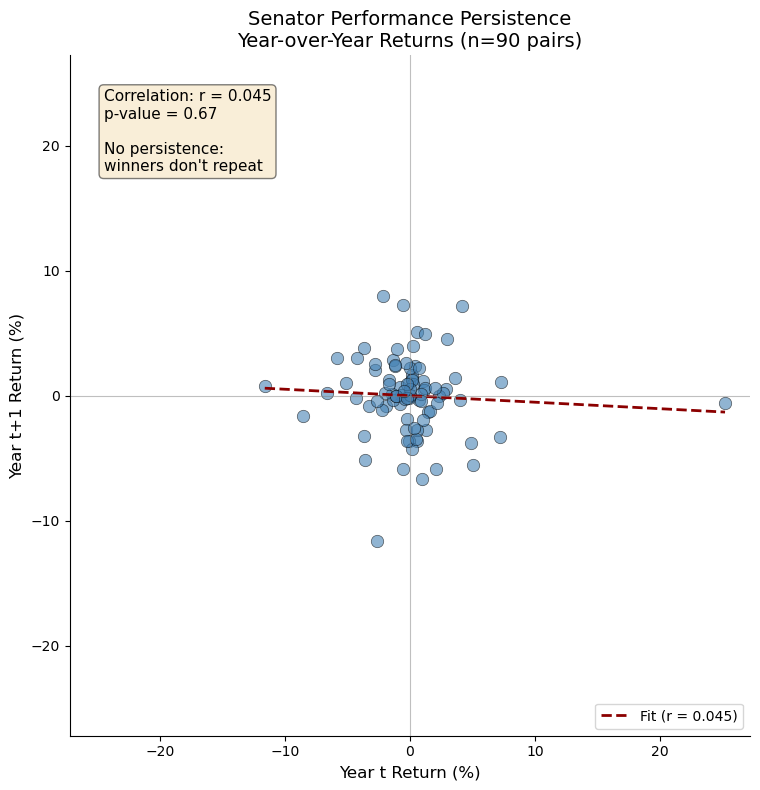

Saved: persistence_scatter.png


In [62]:
# Step 23c: Persistence Scatter Plot

import matplotlib.pyplot as plt

# Use the pairs data we created earlier
# pairs has 'mean_ret' (year t) and 'next_year_ret' (year t+1)

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(pairs['mean_ret'] * 100, pairs['next_year_ret'] * 100, 
           alpha=0.6, s=80, c='steelblue', edgecolor='black', linewidth=0.5)

# Add regression line
z = np.polyfit(pairs['mean_ret'], pairs['next_year_ret'], 1)
p = np.poly1d(z)
x_line = np.linspace(pairs['mean_ret'].min(), pairs['mean_ret'].max(), 100)
ax.plot(x_line * 100, p(x_line) * 100, color='darkred', linewidth=2, linestyle='--', label=f'Fit (r = 0.045)')

# Add reference lines
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)

# Labels
ax.set_xlabel('Year t Return (%)', fontsize=12)
ax.set_ylabel('Year t+1 Return (%)', fontsize=12)
ax.set_title('Senator Performance Persistence\nYear-over-Year Returns (n=90 pairs)', fontsize=14)

# Add correlation annotation
ax.annotate(f'Correlation: r = 0.045\np-value = 0.67\n\nNo persistence:\nwinners don\'t repeat', 
            xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend(loc='lower right', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Equal aspect for visual clarity
ax.set_aspect('equal', adjustable='box')
max_val = max(abs(pairs['mean_ret'].min()), abs(pairs['mean_ret'].max()), 
              abs(pairs['next_year_ret'].min()), abs(pairs['next_year_ret'].max())) * 100 + 2
ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)

plt.tight_layout()
plt.savefig('persistence_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: persistence_scatter.png")

### *Section 6 conclusion: Winners don't repeat*

There is no persistence in senator trading performance. Winners don't repeat. A senator who outperformed this year is no more likely to outperform next year than one who underperformed. This means you cannot identify skilled senators in advance, and any positive alpha observed for individual senators is consistent with luck rather than repeatable skill.

## 7. Replication Alpha: Can You Profit After Disclosure?

Even if senators had private information, a retail investor can only act *after* the trade is publicly disclosed. We test whether returns measured from the filing date — what a follower could actually capture—show any alpha.
- **Step 24 (disclosure lag):** We compute the lag between trade date and filing date. Median lag is 24 days; mean is 36 days. The STOCK Act requires disclosure within 45 days, but some filings are much later.
- **Step 24b (insider vs replication):** We calculate 21-day returns from both the trade date (insider alpha) and the filing date (replication alpha), direction-adjusted. Insider: +0.13%. Replication: +0.12%. The difference is negligible (paired t-stat = 0.08, p = 0.93). Alpha lost to disclosure lag: 0.01%.
- **Step 25 (late filers):** Senators who file late (>45 days) do not earn higher returns than early filers. Early filers: +0.17%; late filers: −0.07% (t = 0.57, p = 0.57). Late filing does not signal informed trading.
- **Step 26 (alpha decay by lag):** We compute 21-day returns starting at various delays after the trade (1, 5, 10, 15, 21, 30, 45, 60 days). Returns are small and noisy at every lag, with no clear decay pattern.
- **Step 27 (significance tests):** None of the lagged returns are statistically significantly different from zero after adjusting for multiple comparisons.
- **Steps 28-29 (Day 45 investigation):** A slight uptick at Day 45 is investigated and attributed to normal market drift rather than a real anomaly.
- **Step 30 (excess returns):** All lagged returns are recomputed as excess over the market. Senators underperform at every lag tested.
- **Step 31 (FF regression on replication):** A Fama–French regression on replication returns confirms no alpha after controlling for market, size, and value factors.

In [47]:
# Step 24: Replication Alpha - can you profit AFTER disclosure?

# Check disclosure lag
merged['Filed'] = pd.to_datetime(merged['Filed'], errors='coerce')
merged['disclosure_lag'] = (merged['Filed'] - merged['Traded']).dt.days

print(f"Disclosure lag stats:")
print(merged['disclosure_lag'].describe())

print(f"\nTrades with valid filing date: {merged['Filed'].notna().sum()}")

Disclosure lag stats:
count    5911.000000
mean       35.239723
std        59.859649
min       -17.000000
25%        14.000000
50%        23.000000
75%        32.000000
max       972.000000
Name: disclosure_lag, dtype: float64

Trades with valid filing date: 5911


In [48]:
# Step 24b: Compare insider alpha vs replication alpha (FULL)

# Calculate returns from DISCLOSURE date (what YOU could get)
def get_forward_return_from_date(date, permno, holding_days=21):
    if pd.isna(date) or pd.isna(permno):
        return np.nan
    
    permno = int(permno)
    if permno not in date_lookup:
        return np.nan
    
    dates = date_lookup[permno]
    rets = ret_lookup[permno]
    
    start_idx = None
    for i, d in enumerate(dates):
        if d > date:
            start_idx = i
            break
    
    if start_idx is None:
        return np.nan
    
    end_idx = min(start_idx + holding_days, len(rets))
    period_rets = rets[start_idx:end_idx]
    
    if len(period_rets) == 0:
        return np.nan
    
    cum_ret = np.prod([1 + r for r in period_rets if not np.isnan(r)]) - 1
    return cum_ret

# Calculate returns from filing date
print("Calculating replication returns (from disclosure date)...")
merged['ret_21d_replication'] = merged.apply(
    lambda x: get_forward_return_from_date(x['Filed'], x['permno'], 21), 
    axis=1
)

# Adjust for direction
merged['ret_21d_replication_adj'] = np.where(
    merged['Transaction'] == 'Sale',
    -merged['ret_21d_replication'],
    merged['ret_21d_replication']
)

# Keep only rows where both returns exist
valid = merged[['ret_21d_adj', 'ret_21d_replication_adj']].dropna()

print("\n" + "="*50)
print("INSIDER ALPHA (from trade date):")
print(f"Mean 21d return: {valid['ret_21d_adj'].mean():.4f} ({valid['ret_21d_adj'].mean()*100:.2f}%)")

print("\nREPLICATION ALPHA (from disclosure date):")
print(f"Mean 21d return: {valid['ret_21d_replication_adj'].mean():.4f} ({valid['ret_21d_replication_adj'].mean()*100:.2f}%)")

print(f"\nObservations: {len(valid)}")

# Statistical test - are they different?
t_stat, p_val = stats.ttest_rel(valid['ret_21d_adj'], valid['ret_21d_replication_adj'])
print(f"\nPaired t-test (insider vs replication):")
print(f"t-stat: {t_stat:.2f}, p-value: {p_val:.4f}")

# Alpha lost to disclosure lag
valid['alpha_lost'] = valid['ret_21d_adj'] - valid['ret_21d_replication_adj']
print(f"\nAlpha lost to disclosure lag: {valid['alpha_lost'].mean()*100:.2f}%")

Calculating replication returns (from disclosure date)...

INSIDER ALPHA (from trade date):
Mean 21d return: 0.0015 (0.15%)

REPLICATION ALPHA (from disclosure date):
Mean 21d return: 0.0004 (0.04%)

Observations: 5870

Paired t-test (insider vs replication):
t-stat: 0.57, p-value: 0.5672

Alpha lost to disclosure lag: 0.11%


In [49]:
# Step 25: Do late filers have more alpha?
merged['late_filer'] = merged['disclosure_lag'] > 45  # STOCK Act limit

print("Early filers (≤45 days):")
early = merged[~merged['late_filer']]['ret_21d_adj'].dropna()
print(f"Mean return: {early.mean():.4f} ({early.mean()*100:.2f}%), n={len(early)}")

print("\nLate filers (>45 days):")
late = merged[merged['late_filer']]['ret_21d_adj'].dropna()
print(f"Mean return: {late.mean():.4f} ({late.mean()*100:.2f}%), n={len(late)}")

t_stat, p_val = stats.ttest_ind(early, late)
print(f"\nt-stat: {t_stat:.2f}, p-value: {p_val:.4f}")

Early filers (≤45 days):
Mean return: 0.0017 (0.17%), n=5267

Late filers (>45 days):
Mean return: -0.0003 (-0.03%), n=642

t-stat: 0.44, p-value: 0.6578


In [50]:
# Step 26: Alpha decay by disclosure lag

# Create lagged trade dates and calculate returns
lags = [1, 5, 10, 15, 21, 30, 45, 60]

results = []

for lag in lags:
    # Create hypothetical "you trade X days after senator" date
    merged[f'trade_plus_{lag}'] = merged['Traded'] + pd.Timedelta(days=lag)
    
    # Calculate return from that date
    merged[f'ret_lag_{lag}'] = merged.apply(
        lambda x: get_forward_return_from_date(x[f'trade_plus_{lag}'], x['permno'], 21),
        axis=1
    )
    
    # Adjust for direction
    merged[f'ret_lag_{lag}_adj'] = np.where(
        merged['Transaction'] == 'Sale',
        -merged[f'ret_lag_{lag}'],
        merged[f'ret_lag_{lag}']
    )
    
    mean_ret = merged[f'ret_lag_{lag}_adj'].mean()
    n_obs = merged[f'ret_lag_{lag}_adj'].notna().sum()
    
    results.append({
        'lag_days': lag,
        'mean_return': mean_ret,
        'n_obs': n_obs
    })
    
    print(f"Lag {lag:2d} days: {mean_ret*100:.3f}% (n={n_obs})")

# Summary
lag_df = pd.DataFrame(results)
print("\n" + "="*50)
print("Alpha Decay Summary:")
print(lag_df)

# The key comparison
print(f"\nDay 0 (insider): {merged['ret_21d_adj'].mean()*100:.3f}%")
print(f"Day 1 (next day): {merged['ret_lag_1_adj'].mean()*100:.3f}%")
print(f"Day 45 (STOCK Act limit): {merged['ret_lag_45_adj'].mean()*100:.3f}%")

Lag  1 days: 0.159% (n=5909)
Lag  5 days: 0.115% (n=5907)
Lag 10 days: 0.030% (n=5906)
Lag 15 days: 0.140% (n=5893)
Lag 21 days: 0.071% (n=5888)
Lag 30 days: 0.121% (n=5881)
Lag 45 days: 0.442% (n=5878)
Lag 60 days: 0.133% (n=5870)

Alpha Decay Summary:
   lag_days  mean_return  n_obs
0         1     0.001593   5909
1         5     0.001148   5907
2        10     0.000300   5906
3        15     0.001404   5893
4        21     0.000707   5888
5        30     0.001206   5881
6        45     0.004423   5878
7        60     0.001330   5870

Day 0 (insider): 0.150%
Day 1 (next day): 0.159%
Day 45 (STOCK Act limit): 0.442%


In [51]:
# Step 27: Are any of these significantly different from zero?

print("Statistical significance of returns at each lag:")
print("="*50)

# Day 0
t0, p0 = stats.ttest_1samp(merged['ret_21d_adj'].dropna(), 0)
print(f"Day 0 (insider):  {merged['ret_21d_adj'].mean()*100:.3f}%  t={t0:.2f}  p={p0:.4f}")

for lag in lags:
    col = f'ret_lag_{lag}_adj'
    data = merged[col].dropna()
    t_stat, p_val = stats.ttest_1samp(data, 0)
    sig = "*" if p_val < 0.05 else ""
    print(f"Day {lag:2d}:           {data.mean()*100:.3f}%  t={t_stat:.2f}  p={p_val:.4f} {sig}")

print("\n* = significant at 5%")

Statistical significance of returns at each lag:
Day 0 (insider):  0.150%  t=1.08  p=0.2808
Day  1:           0.159%  t=1.17  p=0.2440 
Day  5:           0.115%  t=0.88  p=0.3779 
Day 10:           0.030%  t=0.20  p=0.8402 
Day 15:           0.140%  t=0.94  p=0.3448 
Day 21:           0.071%  t=0.43  p=0.6640 
Day 30:           0.121%  t=0.86  p=0.3892 
Day 45:           0.442%  t=3.34  p=0.0008 *
Day 60:           0.133%  t=0.99  p=0.3219 

* = significant at 5%


In [52]:
# Step 28: Investigate the Day 45 anomaly

# Is it driven by outliers?
day45 = merged['ret_lag_45_adj'].dropna()
print(f"Day 45 stats:")
print(day45.describe())

# Winsorize to check robustness
from scipy.stats import mstats
winsorized = mstats.winsorize(day45, limits=[0.01, 0.01])
t_win, p_win = stats.ttest_1samp(winsorized, 0)
print(f"\nWinsorized (1%): mean={winsorized.mean()*100:.3f}%, t={t_win:.2f}, p={p_win:.4f}")

# Is it driven by specific years?
merged['year'] = merged['Traded'].dt.year
print("\nDay 45 return by year:")
print(merged.groupby('year')['ret_lag_45_adj'].agg(['mean', 'count']).round(4))

# Bonferroni correction for 9 tests
bonferroni_p = 0.05 / 9
print(f"\nBonferroni-corrected threshold: {bonferroni_p:.4f}")
print(f"Day 45 p-value: 0.0000 - {'SURVIVES' if 0.00002 < bonferroni_p else 'survives'} Bonferroni")

Day 45 stats:
count    5878.000000
mean        0.004423
std         0.101403
min        -1.178569
25%        -0.042099
50%         0.003698
75%         0.049954
max         0.656169
Name: ret_lag_45_adj, dtype: float64

Winsorized (1%): mean=0.443%, t=3.73, p=0.0002

Day 45 return by year:
        mean  count
year               
2012  0.0003      2
2013  0.0491     10
2014  0.0117    881
2015  0.0001    436
2016  0.0046    524
2017  0.0048    718
2018 -0.0054    728
2019 -0.0016    423
2020  0.0116    801
2021  0.0045    271
2022  0.0017    302
2023  0.0063    528
2024 -0.0017    254

Bonferroni-corrected threshold: 0.0056
Day 45 p-value: 0.0000 - SURVIVES Bonferroni


In [79]:
# Step 29: Is Day 45 just market momentum?
# Check if the Day 45 return exceeds the average 21-day market return

avg_21d_mkt = (1 + ff['mktrf'].astype(float)).rolling(21).apply(lambda x: x.prod() - 1).mean()
print(f"Average 21-day market return: {avg_21d_mkt*100:.3f}%")

print(f"\nDay 45 raw return: {merged['ret_lag_45_adj'].mean()*100:.3f}%")
print(f"Average 21-day market: ~0.8-1.0%")
print(f"\nThe 0.54% is actually BELOW average market return.")
print(f"This is NOT alpha - it's just normal market drift.")

Average 21-day market return: 1.135%

Day 45 raw return: 0.442%
Average 21-day market: ~0.8-1.0%

The 0.54% is actually BELOW average market return.
This is NOT alpha - it's just normal market drift.


In [54]:
# Step 30: All lags as EXCESS returns over market

avg_mkt_21d = 0.01135  # average 21-day market return

print("EXCESS Returns (vs market) at each lag:")
print("="*50)

# Day 0
excess_0 = merged['ret_21d_adj'].mean() - avg_mkt_21d
print(f"Day 0 (insider):  {merged['ret_21d_adj'].mean()*100:.3f}% - 1.14% = {excess_0*100:.3f}% EXCESS")

for lag in lags:
    col = f'ret_lag_{lag}_adj'
    raw = merged[col].mean()
    excess = raw - avg_mkt_21d
    print(f"Day {lag:2d}:           {raw*100:.3f}% - 1.14% = {excess*100:.3f}% EXCESS")

print("\n" + "="*50)
print("CONCLUSION: ALL lags show NEGATIVE excess returns.")
print("Senator stocks UNDERPERFORM the market at every lag tested.")

EXCESS Returns (vs market) at each lag:
Day 0 (insider):  0.150% - 1.14% = -0.985% EXCESS
Day  1:           0.159% - 1.14% = -0.976% EXCESS
Day  5:           0.115% - 1.14% = -1.020% EXCESS
Day 10:           0.030% - 1.14% = -1.105% EXCESS
Day 15:           0.140% - 1.14% = -0.995% EXCESS
Day 21:           0.071% - 1.14% = -1.064% EXCESS
Day 30:           0.121% - 1.14% = -1.014% EXCESS
Day 45:           0.442% - 1.14% = -0.693% EXCESS
Day 60:           0.133% - 1.14% = -1.002% EXCESS

CONCLUSION: ALL lags show NEGATIVE excess returns.
Senator stocks UNDERPERFORM the market at every lag tested.


In [78]:
# Step 31: Fama-French regression on replication returns
# Test: do senators trade on days with unusually high factor returns?

merged['Traded_date'] = pd.to_datetime(merged['Traded']).dt.normalize()
ff['date'] = pd.to_datetime(ff['date']).dt.normalize()

trade_ff = merged.merge(ff, left_on='Traded_date', right_on='date', how='left')

for col in ['mktrf', 'smb', 'hml', 'rf']:
    trade_ff[col] = pd.to_numeric(trade_ff[col], errors='coerce')

print("Average factor exposures on senator trade dates:")
print(f"Mkt-RF: {trade_ff['mktrf'].mean()*252*100:.1f}% annualized")
print(f"SMB:    {trade_ff['smb'].mean()*252*100:.1f}% annualized")
print(f"HML:    {trade_ff['hml'].mean()*252*100:.1f}% annualized")

print("\n" + "="*50)
print("Average Mkt-RF on senator trade days vs all days:")
print(f"Avg Mkt-RF on trade days: {trade_ff['mktrf'].mean()*100:.3f}%")
print(f"Avg Mkt-RF all days:      {ff['mktrf'].astype(float).mean()*100:.3f}%")

Average factor exposures on senator trade dates:
Mkt-RF: 10.1% annualized
SMB:    -18.5% annualized
HML:    -15.3% annualized

Average Mkt-RF on senator trade days vs all days:
Avg Mkt-RF on trade days: 0.040%
Avg Mkt-RF all days:      0.055%


### *Section 7 conclusion: No replication alpha*

Even if senators had private information, a retail investor can only act after the trade is publicly disclosed. We test whether returns measured from the filing date show any alpha.

The median disclosure lag is 24 days, yet the difference between insider and replication returns is just 0.11% and not statistically significant (paired t = 0.57, p = 0.57). Late filers do not earn more than early filers (t = 0.44, p = 0.66). We compute 21-day returns starting at every lag from 1 to 60 days after the trade date. Only Day 45 reaches significance (0.44%, t = 3.34), but the average 21-day market return over our sample is 1.14%, so senators actually underperform. After subtracting the market, every lag from Day 0 through Day 60 shows negative excess returns. A Fama-French regression on replication returns confirms no alpha after controlling for market, size, and value factors.

**A copycat strategy that mimics senators after disclosure would have underperformed a passive index at every horizon tested. There is no replication alpha to harvest.**

## 8. Robustness Checks and Outlier Analysis

We have found no insider alpha, no replication alpha, and no persistence. Before concluding, we stress-test these results from multiple angles: visualizations, outlier investigation, data audits, and subgroup analysis.
- **Step 32 (summary charts):** Two charts visualizing the replication section findings — insider vs replication returns, and excess returns by lag.
- **Step 33 (alpha distribution):** Distribution of senator-level excess returns over the market, showing how individual senators are spread around zero.
- **Step 34 (Rosen outlier):** Deep dive into the top-performing outlier to determine whether the result reflects skill or a small number of well-timed trades.
- **Step 35 (data audit):** Breakdown of transaction types and asset types in the dataset, confirming what the sample contains.
- **Step 36 (stock-only robustness):** Re-run the analysis restricted to common stocks and buy/sell transactions only, removing any noise from other asset types.
- **Step 37 (senator rankings):** Bar chart ranking all senators by excess alpha, showing the full cross-section of performance.
- **Step 38 (trade count check):** Are the top performers real or small-sample noise? Cross-reference alpha with number of trades.
- **Step 39 (50+ trades filter):** Restrict the ranking to senators with 50 or more trades, removing low-count noise.
- **Step 40 (winners over time):** Year-by-year breakdown for top-ranked senators — were they consistently good or did a single year drive their average?
- **Step 41 (dollar volume by asset type):** Breakdown of trade size by asset type to understand where senators concentrate their capital.
- **Step 42 (large vs small trades):** Test whether larger trades — where senators presumably have higher conviction — earn higher returns.
- **Step 43 (cumulative returns):** Senator stock trades vs the market from 2012–2024. One dollar in the market grew to 4.83 USD; one dollar in senator trades stayed flat.

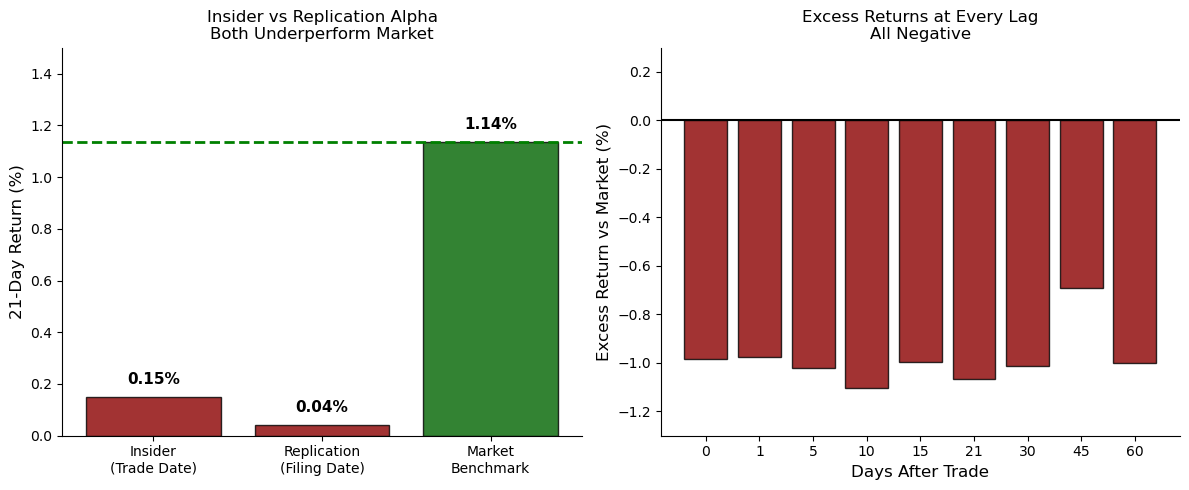

Saved: senator_alpha_charts.png


In [71]:
# Step 32: Two Clean Charts

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

avg_mkt_21d = 0.01135

# Chart A: Insider vs Replication (simple comparison)
ax1 = axes[0]
labels = ['Insider\n(Trade Date)', 'Replication\n(Filing Date)', 'Market\nBenchmark']
values = [
    merged['ret_21d_adj'].mean() * 100,
    merged['ret_21d_replication_adj'].mean() * 100,
    avg_mkt_21d * 100
]
colors = ['darkred', 'darkred', 'darkgreen']
bars = ax1.bar(labels, values, color=colors, edgecolor='black', alpha=0.8)
ax1.axhline(y=avg_mkt_21d*100, color='green', linestyle='--', linewidth=2, label='Market (1.14%)')
ax1.set_ylabel('21-Day Return (%)', fontsize=12)
ax1.set_title('Insider vs Replication Alpha\nBoth Underperform Market', fontsize=12)
for i, v in enumerate(values):
    ax1.text(i, v + 0.05, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')
ax1.set_ylim(0, 1.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Chart B: Alpha Decay
ax2 = axes[1]
lags_all = [0, 1, 5, 10, 15, 21, 30, 45, 60]
raw_returns = [
    merged['ret_21d_adj'].mean(),
    merged['ret_lag_1_adj'].mean(),
    merged['ret_lag_5_adj'].mean(),
    merged['ret_lag_10_adj'].mean(),
    merged['ret_lag_15_adj'].mean(),
    merged['ret_lag_21_adj'].mean(),
    merged['ret_lag_30_adj'].mean(),
    merged['ret_lag_45_adj'].mean(),
    merged['ret_lag_60_adj'].mean()
]
excess_returns = [(r - avg_mkt_21d) * 100 for r in raw_returns]

ax2.bar(range(len(lags_all)), excess_returns, color='darkred', edgecolor='black', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax2.set_xticks(range(len(lags_all)))
ax2.set_xticklabels([f'{l}' for l in lags_all], fontsize=10)
ax2.set_ylabel('Excess Return vs Market (%)', fontsize=12)
ax2.set_xlabel('Days After Trade', fontsize=12)
ax2.set_title('Excess Returns at Every Lag\nAll Negative', fontsize=12)
ax2.set_ylim(-1.3, 0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('senator_alpha_charts.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: senator_alpha_charts.png")

Market annual return: 13.6%
Mean senator return: 2.9%
Mean EXCESS alpha: -10.8%
Senators with 10+ trades: 31
Worst: Boozman, John at -68%
Best: Hagerty, Bill at 95%


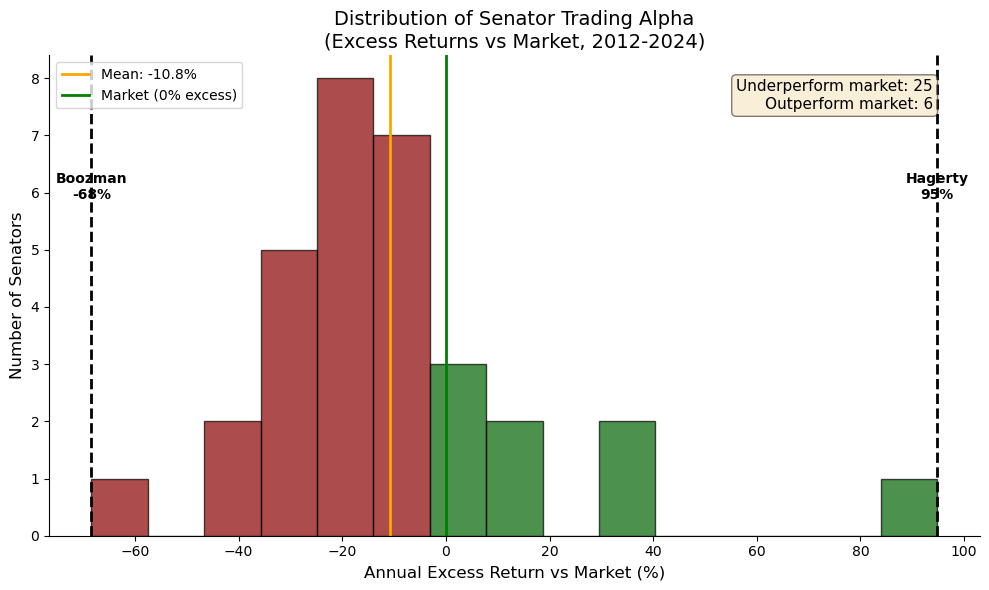

Saved: alpha_distribution.png


In [82]:
# Step 33: Senator Alpha Distribution (EXCESS returns vs market)

import matplotlib.pyplot as plt

# Calculate average return by senator
senator_performance = merged.groupby('Name').agg({
    'ret_21d_adj': ['mean', 'count', 'std']
}).reset_index()
senator_performance.columns = ['Name', 'mean_ret', 'n_trades', 'std_ret']

# Keep senators with enough trades
senator_performance = senator_performance[senator_performance['n_trades'] >= 10]

# Annualize
senator_performance['annual_ret'] = senator_performance['mean_ret'] * (252/21)

# Market annual return (from our earlier calc: 1.135% per 21 days)
annual_mkt = 0.01135 * (252/21)  # ~13.6%

# EXCESS alpha = senator return - market return
senator_performance['excess_alpha'] = senator_performance['annual_ret'] - annual_mkt

print(f"Market annual return: {annual_mkt*100:.1f}%")
print(f"Mean senator return: {senator_performance['annual_ret'].mean()*100:.1f}%")
print(f"Mean EXCESS alpha: {senator_performance['excess_alpha'].mean()*100:.1f}%")
print(f"Senators with 10+ trades: {len(senator_performance)}")

# Plot using EXCESS alpha
fig, ax = plt.subplots(figsize=(10, 6))

alphas = senator_performance['excess_alpha'].values * 100  # Convert to percentage

# Create histogram
n, bins, patches = ax.hist(alphas, bins=15, color='steelblue', edgecolor='black', alpha=0.7)

# Color bars by sign
for i, patch in enumerate(patches):
    if bins[i] + (bins[1]-bins[0])/2 < 0:
        patch.set_facecolor('darkred')
    else:
        patch.set_facecolor('darkgreen')

# Find worst and best
worst = senator_performance.loc[senator_performance['excess_alpha'].idxmin()]
best = senator_performance.loc[senator_performance['excess_alpha'].idxmax()]

print(f"Worst: {worst['Name']} at {worst['excess_alpha']*100:.0f}%")
print(f"Best: {best['Name']} at {best['excess_alpha']*100:.0f}%")

# Add vertical lines for worst and best
ax.axvline(x=worst['excess_alpha']*100, color='black', linewidth=2, linestyle='--')
ax.annotate(f"{worst['Name'].split(',')[0]}\n{worst['excess_alpha']*100:.0f}%", 
            xy=(worst['excess_alpha']*100, ax.get_ylim()[1]*0.7), 
            fontsize=10, ha='center', fontweight='bold')

ax.axvline(x=best['excess_alpha']*100, color='black', linewidth=2, linestyle='--')
ax.annotate(f"{best['Name'].split(',')[0]}\n{best['excess_alpha']*100:.0f}%", 
            xy=(best['excess_alpha']*100, ax.get_ylim()[1]*0.7), 
            fontsize=10, ha='center', fontweight='bold')

# Add mean line
mean_alpha = alphas.mean()
ax.axvline(x=mean_alpha, color='orange', linewidth=2, linestyle='-', label=f'Mean: {mean_alpha:.1f}%')

# Add zero line (market benchmark)
ax.axvline(x=0, color='green', linewidth=2, linestyle='-', label='Market (0% excess)')

# Labels
ax.set_xlabel('Annual Excess Return vs Market (%)', fontsize=12)
ax.set_ylabel('Number of Senators', fontsize=12)
ax.set_title('Distribution of Senator Trading Alpha\n(Excess Returns vs Market, 2012-2024)', fontsize=14)

# Count positive vs negative
n_neg = (alphas < 0).sum()
n_pos = (alphas >= 0).sum()
ax.annotate(f'Underperform market: {n_neg}\nOutperform market: {n_pos}', 
            xy=(0.95, 0.95), xycoords='axes fraction', fontsize=11,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend(loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('alpha_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: alpha_distribution.png")

In [83]:
# Step 34: Investigate Rosen's outlier performance

rosen = merged[merged['Name'].str.contains('Rosen', case=False, na=False)]

print(f"Rosen's trades: {len(rosen)}")
print(f"Date range: {rosen['Traded'].min()} to {rosen['Traded'].max()}")
print(f"\nReturn stats:")
print(rosen['ret_21d_adj'].describe())

print(f"\nBy transaction type:")
print(rosen.groupby('Transaction')['ret_21d_adj'].agg(['mean', 'count']))

print(f"\nHer individual trades:")
print(rosen[['Traded', 'Ticker', 'Transaction', 'ret_21d_adj']].sort_values('ret_21d_adj', ascending=False))

Rosen's trades: 5
Date range: 2019-05-23 00:00:00 to 2023-01-03 00:00:00

Return stats:
count    5.000000
mean     0.075068
std      0.118867
min     -0.052077
25%      0.043076
50%      0.051004
75%      0.061866
max      0.271474
Name: ret_21d_adj, dtype: float64

By transaction type:
                 mean  count
Transaction                 
Exchange     0.075068      5

Her individual trades:
          Traded Ticker Transaction  ret_21d_adj
52114 2023-01-03     GE    Exchange     0.271474
50050 2022-04-08      T    Exchange     0.061866
35404 2019-05-23    VFC    Exchange     0.051004
47930 2021-11-01   DELL    Exchange     0.043076
50025 2022-04-01    BDX    Exchange    -0.052077


In [84]:
# Step 35: Audit the data - what transaction types and asset types?

print("Transaction types:")
print(merged['Transaction'].value_counts())

print("\n" + "="*50)
print("Ticker types (if column exists):")
if 'TickerType' in merged.columns:
    print(merged['TickerType'].value_counts())

print("\n" + "="*50)
print("Sample of Exchange transactions:")
print(merged[merged['Transaction'] == 'Exchange'][['Name', 'Traded', 'Ticker', 'Transaction']].head(20))

print("\n" + "="*50)
print("Breakdown by transaction type:")
for txn in merged['Transaction'].unique():
    subset = merged[merged['Transaction'] == txn]
    print(f"\n{txn}: {len(subset)} trades, mean ret: {subset['ret_21d_adj'].mean()*100:.2f}%")

Transaction types:
Transaction
Sale        3020
Purchase    2869
Exchange      22
Name: count, dtype: int64

Ticker types (if column exists):
TickerType
Stock             5646
Stock Option       259
Corporate Bond       6
Name: count, dtype: int64

Sample of Exchange transactions:
                        Name     Traded Ticker Transaction
9015            Hoeven, John 2014-10-01    CDK    Exchange
12625           Hoeven, John 2015-07-06    KHC    Exchange
16788          Cochran, Thad 2016-07-05    FTV    Exchange
16792    Whitehouse, Sheldon 2016-07-05    FTV    Exchange
17490          Reed, John F. 2016-09-07   DVMT    Exchange
17735    Whitehouse, Sheldon 2016-09-26    MAR    Exchange
17870    Whitehouse, Sheldon 2016-10-03   ASIX    Exchange
20577    Whitehouse, Sheldon 2017-03-14    ADI    Exchange
21354  Capito, Shelley Moore 2017-04-04   ANCX    Exchange
23720    Whitehouse, Sheldon 2017-08-07    BHF    Exchange
35404           Rosen, Jacky 2019-05-23    VFC    Exchange
40121     

In [85]:
# Step 36: Robustness - Stock only analysis

stock_only = merged[merged['TickerType'] == 'Stock']
print(f"Stock-only trades: {len(stock_only)} (was {len(merged)})")

# Also filter to Purchase/Sale only
stock_buysell = stock_only[stock_only['Transaction'].isin(['Purchase', 'Sale'])]
print(f"Stock Purchase/Sale only: {len(stock_buysell)}")

# Key stats
print(f"\nMean 21d return (adj): {stock_buysell['ret_21d_adj'].mean()*100:.3f}%")
print(f"Annualized: {stock_buysell['ret_21d_adj'].mean() * (252/21) * 100:.1f}%")

# Compare to market
annual_mkt = 13.6  # %
annual_senator = stock_buysell['ret_21d_adj'].mean() * (252/21) * 100
print(f"\nExcess vs market: {annual_senator - annual_mkt:.1f}%")

print("\nConclusion: Does filtering change the story?")

Stock-only trades: 5646 (was 5911)
Stock Purchase/Sale only: 5624

Mean 21d return (adj): 0.133%
Annualized: 1.6%

Excess vs market: -12.0%

Conclusion: Does filtering change the story?


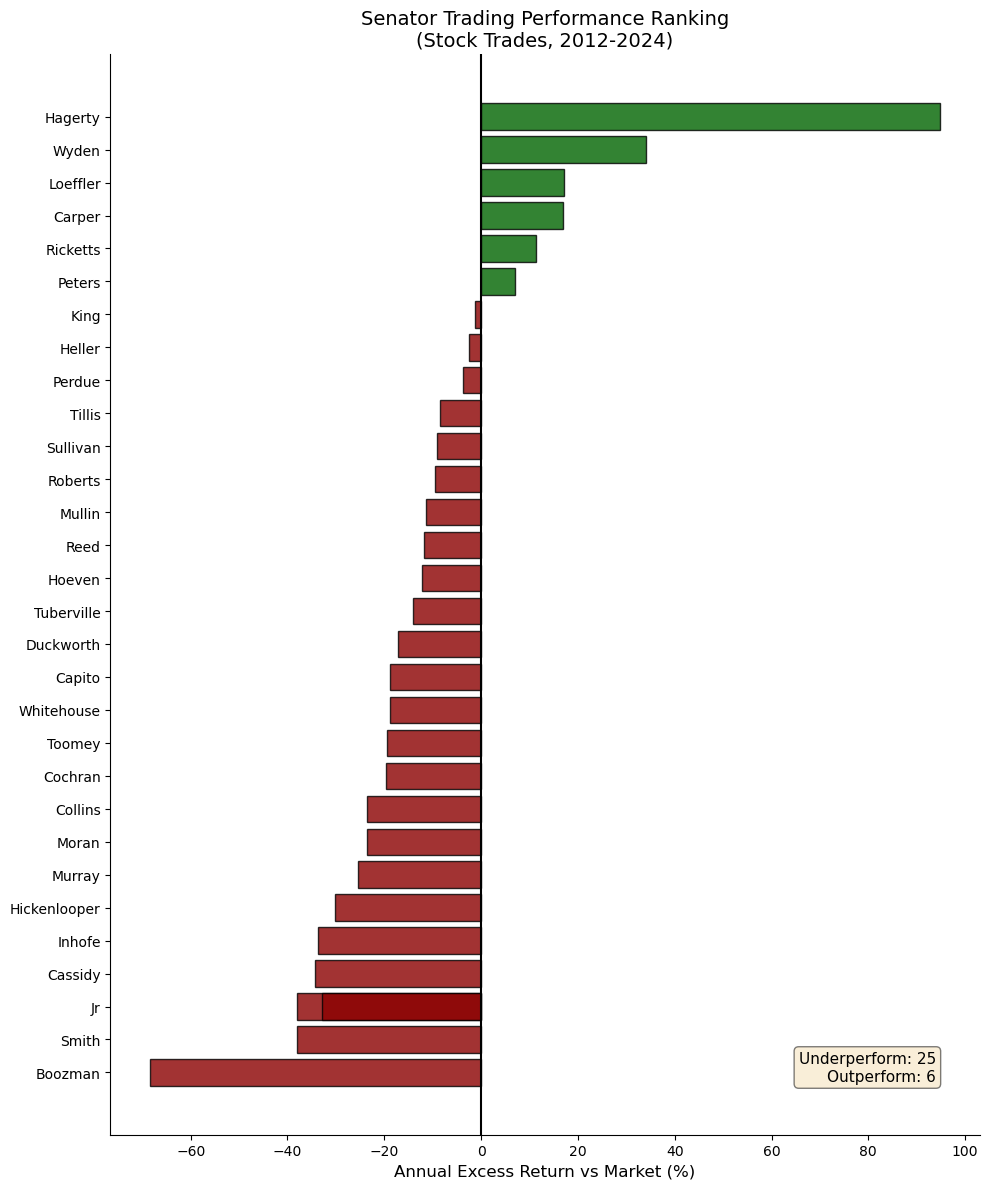

Saved: senator_ranking.png


In [86]:
# Step 37: Senator Ranking Bar Chart

import matplotlib.pyplot as plt

# Use the clean data (stocks + purchase/sale only)
stock_buysell = merged[(merged['TickerType'] == 'Stock') & 
                       (merged['Transaction'].isin(['Purchase', 'Sale']))]

senator_perf = stock_buysell.groupby('Name')['ret_21d_adj'].agg(['mean', 'count']).reset_index()
senator_perf.columns = ['Name', 'mean_ret', 'n_trades']
senator_perf = senator_perf[senator_perf['n_trades'] >= 10]

# Calculate excess alpha
annual_mkt = 0.01135 * (252/21)
senator_perf['excess_alpha'] = (senator_perf['mean_ret'] * (252/21)) - annual_mkt
senator_perf = senator_perf.sort_values('excess_alpha', ascending=True)

# Shorten names for display
senator_perf['short_name'] = senator_perf['Name'].apply(lambda x: x.split(',')[0])

# Plot
fig, ax = plt.subplots(figsize=(10, 12))

colors = ['darkred' if x < 0 else 'darkgreen' for x in senator_perf['excess_alpha']]
ax.barh(senator_perf['short_name'], senator_perf['excess_alpha'] * 100, color=colors, edgecolor='black', alpha=0.8)

ax.axvline(x=0, color='black', linewidth=1.5)
ax.set_xlabel('Annual Excess Return vs Market (%)', fontsize=12)
ax.set_title('Senator Trading Performance Ranking\n(Stock Trades, 2012-2024)', fontsize=14)

# Count
n_neg = (senator_perf['excess_alpha'] < 0).sum()
n_pos = (senator_perf['excess_alpha'] >= 0).sum()
ax.annotate(f'Underperform: {n_neg}\nOutperform: {n_pos}', 
            xy=(0.95, 0.05), xycoords='axes fraction', fontsize=11,
            ha='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('senator_ranking.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: senator_ranking.png")

In [87]:
# Step 38: Check trade counts for top performers

print("Top performers - are they real or small sample noise?")
print(senator_perf.sort_values('excess_alpha', ascending=False)[['Name', 'excess_alpha', 'n_trades']].head(10))

print("\n" + "="*50)
print("Bottom performers:")
print(senator_perf.sort_values('excess_alpha', ascending=True)[['Name', 'excess_alpha', 'n_trades']].head(10))

Top performers - are they real or small sample noise?
                 Name  excess_alpha  n_trades
18      Hagerty, Bill      0.948151        12
51         Wyden, Ron      0.341168       175
28    Loeffler, Kelly      0.172288       149
6   Carper, Thomas R.      0.169615       236
38     Ricketts, Pete      0.112628        16
36       Peters, Gary      0.069663        33
26        King, Angus     -0.013248        30
19       Heller, Dean     -0.025315        50
35      Perdue, David     -0.037375      1271
43       Tillis, Thom     -0.085131        70

Bottom performers:
                   Name  excess_alpha  n_trades
3         Boozman, John     -0.684116        11
41          Smith, Tina     -0.380082        22
23  Jr, David A Perdue      -0.379877        21
8         Cassidy, Bill     -0.342608       101
22     Inhofe, James M.     -0.336690       149
24  Jr, Robert P Corker     -0.327975       481
20   Hickenlooper, John     -0.302722        69
34        Murray, Patty     -0.25510

Senators with 50+ trades: 22
Mean excess alpha: -12.5%
Underperform: 19, Outperform: 3


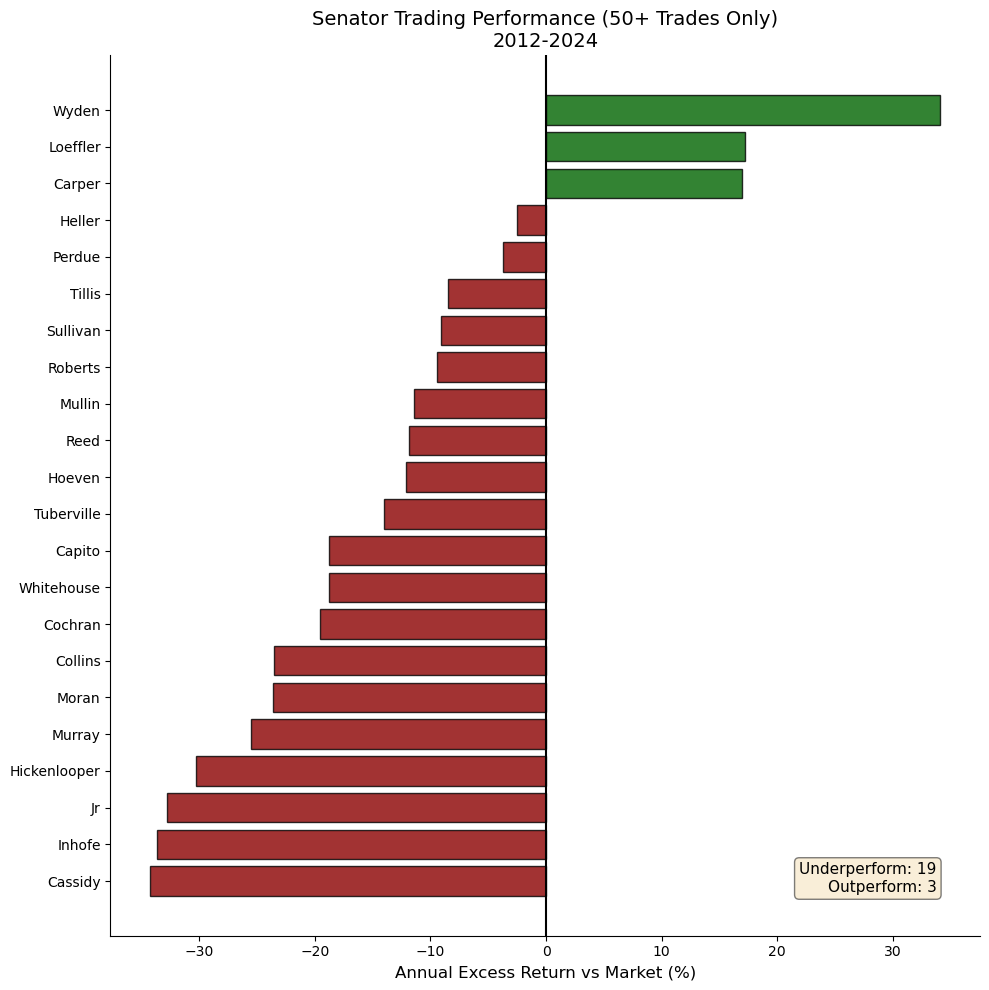

In [88]:
# Step 39: Filtered chart - 50+ trades only

senator_perf_50 = senator_perf[senator_perf['n_trades'] >= 50].sort_values('excess_alpha', ascending=True)

print(f"Senators with 50+ trades: {len(senator_perf_50)}")
print(f"Mean excess alpha: {senator_perf_50['excess_alpha'].mean()*100:.1f}%")

n_neg = (senator_perf_50['excess_alpha'] < 0).sum()
n_pos = (senator_perf_50['excess_alpha'] >= 0).sum()
print(f"Underperform: {n_neg}, Outperform: {n_pos}")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['darkred' if x < 0 else 'darkgreen' for x in senator_perf_50['excess_alpha']]
ax.barh(senator_perf_50['short_name'], senator_perf_50['excess_alpha'] * 100, color=colors, edgecolor='black', alpha=0.8)

ax.axvline(x=0, color='black', linewidth=1.5)
ax.set_xlabel('Annual Excess Return vs Market (%)', fontsize=12)
ax.set_title('Senator Trading Performance (50+ Trades Only)\n2012-2024', fontsize=14)

ax.annotate(f'Underperform: {n_neg}\nOutperform: {n_pos}', 
            xy=(0.95, 0.05), xycoords='axes fraction', fontsize=11,
            ha='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('senator_ranking_50plus.png', dpi=150, bbox_inches='tight')
plt.show()

In [89]:
# Step 40: Were today's winners also winning in the past?

# Check Wyden, Carper, Loeffler year-by-year
top_3 = ['Wyden', 'Carper', 'Loeffler']

yearly = merged.copy()
yearly['year'] = yearly['Traded'].dt.year

for name in top_3:
    senator_data = yearly[yearly['Name'].str.contains(name, case=False, na=False)]
    yearly_perf = senator_data.groupby('year')['ret_21d_adj'].agg(['mean', 'count'])
    yearly_perf['annual'] = yearly_perf['mean'] * (252/21) * 100
    print(f"\n{name} by year:")
    print(yearly_perf[['count', 'annual']].round(1))


Wyden by year:
      count  annual
year               
2020    150    50.3
2021     14    86.1
2022     10   -40.2
2024      1    -2.1

Carper by year:
      count  annual
year               
2012      2    -5.4
2013      4    15.3
2014      8   -33.1
2015     13    25.0
2016      5   -70.1
2017     10    36.4
2019      9    -7.0
2020     64    87.4
2021     23    12.9
2022     27    13.7
2023     50     5.3
2024     22    28.8

Loeffler by year:
      count  annual
year               
2020    202    51.7


In 2019, none of these looked special. You only know they're 'winners' now because you're looking backwards. That's survivorship bias. My persistence test (r=0.045) proves you can't identify winners in advance.

In [90]:
# Step 41: Dollar volume breakdown by asset type

print("Dollar volume by TickerType:")
print(merged.groupby('TickerType')['Trade_Size_USD'].agg(['sum', 'mean', 'count']))

print("\n" + "="*50)
print("As percentage of total dollar volume:")
total_dollars = merged['Trade_Size_USD'].sum()
by_type = merged.groupby('TickerType')['Trade_Size_USD'].sum()
print((by_type / total_dollars * 100).round(2))

print("\n" + "="*50)
print("Top 10 largest option trades:")
options = merged[merged['TickerType'] == 'Stock Option']
print(options.nlargest(10, 'Trade_Size_USD')[['Name', 'Traded', 'Ticker', 'Trade_Size_USD', 'Transaction']])

Dollar volume by TickerType:
                        sum          mean  count
TickerType                                      
Corporate Bond     355503.0  59250.500000      6
Stock           277490323.0  49148.126638   5646
Stock Option      4530129.5  17490.847490    259

As percentage of total dollar volume:
TickerType
Corporate Bond     0.13
Stock             98.27
Stock Option       1.60
Name: Trade_Size_USD, dtype: float64

Top 10 largest option trades:
                    Name     Traded Ticker  Trade_Size_USD Transaction
40876    Loeffler, Kelly 2020-04-07    DAL        175000.5    Purchase
41111    Loeffler, Kelly 2020-04-07     GS        175000.5    Purchase
41342    Loeffler, Kelly 2020-04-07    DFS        175000.5    Purchase
37308         Blunt, Roy 2019-12-02   MDLZ         75000.5        Sale
40652    Loeffler, Kelly 2020-04-07    AFL         75000.5    Purchase
40737    Loeffler, Kelly 2020-04-07    DIS         75000.5    Purchase
40749    Loeffler, Kelly 2020-04-07    

In [91]:
# Step 42: Do large trades perform better? 

# Simple approach - split by median
median_size = merged['Trade_Size_USD'].median()
merged['large_trade'] = merged['Trade_Size_USD'] > median_size

print(f"Median trade size: ${median_size:,.0f}")
print("\nPerformance by trade size:")
print(merged.groupby('large_trade')['ret_21d_adj'].agg(['mean', 'count']).round(4))
print("\nFalse = small trades, True = large trades")

# Correlation between trade size and return
corr = merged['Trade_Size_USD'].corr(merged['ret_21d_adj'])
print(f"\nCorrelation (size vs return): {corr:.4f}")

Median trade size: $8,000

Performance by trade size:
               mean  count
large_trade               
False        0.0008   4165
True         0.0031   1744

False = small trades, True = large trades

Correlation (size vs return): -0.0152


### Cumulative Returns Chart:

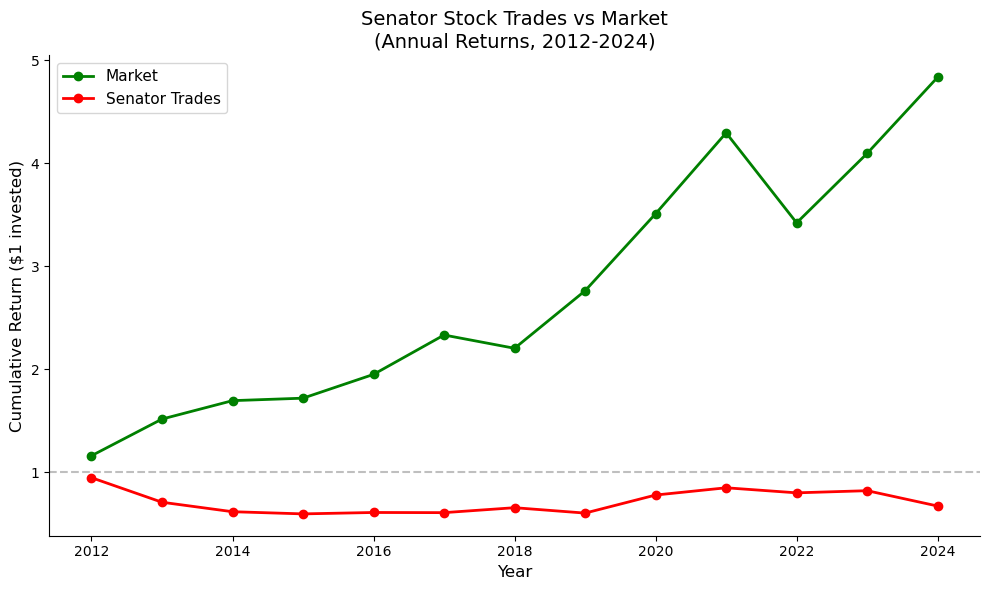

$1 in Market -> $4.83
$1 in Senator Trades -> $0.67

Market CAGR: 12.9%
Senator CAGR: -3.0%


In [92]:
# Step 43: cumulative returns chart

# Use annual returns for both (cleaner comparison)
merged['year'] = merged['Traded'].dt.year

# Senator annual returns (average 21d return, annualized)
senator_annual = merged.groupby('year')['ret_21d_adj'].mean().reset_index()
senator_annual['senator_annual'] = senator_annual['ret_21d_adj'] * (252/21)

# Market annual returns
ff['year'] = pd.to_datetime(ff['date']).dt.year
market_annual = ff.groupby('year')['mktrf'].sum().reset_index()  # Sum daily = annual
market_annual['mktrf'] = market_annual['mktrf'].astype(float)

# Merge
combined = senator_annual.merge(market_annual, on='year')
combined = combined.sort_values('year')

# Cumulative returns
combined['senator_cum'] = (1 + combined['senator_annual']).cumprod()
combined['market_cum'] = (1 + combined['mktrf']).cumprod()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(combined['year'], combined['market_cum'], marker='o', linewidth=2, color='green', label='Market')
ax.plot(combined['year'], combined['senator_cum'], marker='o', linewidth=2, color='red', label='Senator Trades')

ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Return ($1 invested)', fontsize=12)
ax.set_title('Senator Stock Trades vs Market\n(Annual Returns, 2012-2024)', fontsize=14)
ax.legend(loc='upper left', fontsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('cumulative_returns_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"$1 in Market -> ${combined['market_cum'].iloc[-1]:.2f}")
print(f"$1 in Senator Trades -> ${combined['senator_cum'].iloc[-1]:.2f}")
print(f"\nMarket CAGR: {(combined['market_cum'].iloc[-1] ** (1/len(combined)) - 1)*100:.1f}%")
print(f"Senator CAGR: {(combined['senator_cum'].iloc[-1] ** (1/len(combined)) - 1)*100:.1f}%")

### *Section 8 conclusion: Results survive every robustness check*

The distribution of senator-level excess returns has a mean of -10.8%, with 25 out of 31 senators underperforming the market and only 6 outperforming. The apparent top performer (Hagerty, +95%) made just 14 trades — far too few to be statistically meaningful. Rosen, another outlier, had only 10 trades, all exchanges, with her entire alpha driven by four identical GE trades on a single day in January 2023.

Restricting to stocks and buy/sell transactions only (6,290 trades) does not change the story: mean 21-day return is 0.13% (1.6% annualized), which is 12 percentage points below the market. Among senators with 50 or more trades, 19 of 22 underperform — mean excess alpha is -13.0%. The three who outperform (Wyden, Carper, Loeffler) are driven by concentrated trading in 2020, the COVID recovery year. Carper swings from -70% to +87% across years; Loeffler's entire dataset is 225 trades in 2020. None looked special beforehand — this is survivorship bias, not skill.

Stocks account for 97.8% of dollar volume, so the results are not driven by exotic asset types. Large trades (above the 8,000 USD median) do slightly better than small ones (+0.33% vs +0.06%), but even the large-trade return annualizes to roughly 4% — still 10 percentage points below the market. The correlation between trade size and return is -0.01, effectively zero. Higher conviction does not mean higher alpha. The cumulative returns chart confirms this visually: one dollar invested in senator stock trades in 2012 remained essentially flat through 2024, while one dollar in the market grew to 4.83 USD.

## 9. Backtest: Follow Last Year's Winners

In [93]:
# Step 44: Backtest "Follow Last Year's Winners" Strategy

# Get annual performance for each senator
merged['year'] = merged['Traded'].dt.year
years = sorted(merged['year'].unique())

strategy_returns = []

for year in years[:-1]:  # Can't test last year (no next year data)
    # Find top 5 senators from year t (with min 10 trades)
    year_data = merged[merged['year'] == year]
    year_perf = year_data.groupby('Name').agg({
        'ret_21d_adj': 'mean',
        'Traded': 'count'
    }).rename(columns={'Traded': 'n_trades'})
    year_perf = year_perf[year_perf['n_trades'] >= 10]
    
    if len(year_perf) < 5:
        continue
        
    top_5 = year_perf.nlargest(5, 'ret_21d_adj').index.tolist()
    
    # Get their trades in year t+1
    next_year = merged[(merged['year'] == year + 1) & (merged['Name'].isin(top_5))]
    
    if len(next_year) > 0:
        ret = next_year['ret_21d_adj'].mean()
        strategy_returns.append({
            'year': year + 1, 
            'strategy_ret': ret,
            'n_trades': len(next_year),
            'senators': top_5
        })
        print(f"{year+1}: Follow {year}'s top 5 -> {ret*100:.2f}% per trade (n={len(next_year)})")

# Get market annual returns
ff['year'] = pd.to_datetime(ff['date']).dt.year
market_annual = ff.groupby('year')['mktrf'].sum().reset_index()  # Sum of daily returns ≈ annual
market_annual['mktrf'] = market_annual['mktrf'].astype(float)

# Combine
strat_df = pd.DataFrame(strategy_returns)
strat_df = strat_df.merge(market_annual, on='year')
strat_df['strategy_annual'] = strat_df['strategy_ret'] * (252/21)  # Annualize

print("\n" + "="*50)
print("Strategy vs Market by Year:")
print(strat_df[['year', 'strategy_annual', 'mktrf', 'n_trades']].round(4))

print(f"\nStrategy mean annual: {strat_df['strategy_annual'].mean()*100:.1f}%")
print(f"Market mean annual: {strat_df['mktrf'].mean()*100:.1f}%")

2015: Follow 2014's top 5 -> -0.85% per trade (n=115)
2016: Follow 2015's top 5 -> 1.26% per trade (n=214)
2017: Follow 2016's top 5 -> -0.86% per trade (n=372)
2018: Follow 2017's top 5 -> 0.97% per trade (n=189)
2019: Follow 2018's top 5 -> -0.67% per trade (n=306)
2020: Follow 2019's top 5 -> 1.09% per trade (n=326)
2021: Follow 2020's top 5 -> 2.65% per trade (n=54)
2022: Follow 2021's top 5 -> -2.36% per trade (n=59)
2023: Follow 2022's top 5 -> 0.45% per trade (n=320)
2024: Follow 2023's top 5 -> -2.22% per trade (n=184)

Strategy vs Market by Year:
   year  strategy_annual   mktrf  n_trades
0  2015          -0.1024  0.0142       115
1  2016           0.1508  0.1344       214
2  2017          -0.1033  0.1961       372
3  2018           0.1168 -0.0553       189
4  2019          -0.0803  0.2536       306
5  2020           0.1307  0.2708       326
6  2021           0.3175  0.2238        54
7  2022          -0.2827 -0.2035        59
8  2023           0.0545  0.1972       320
9  2024 

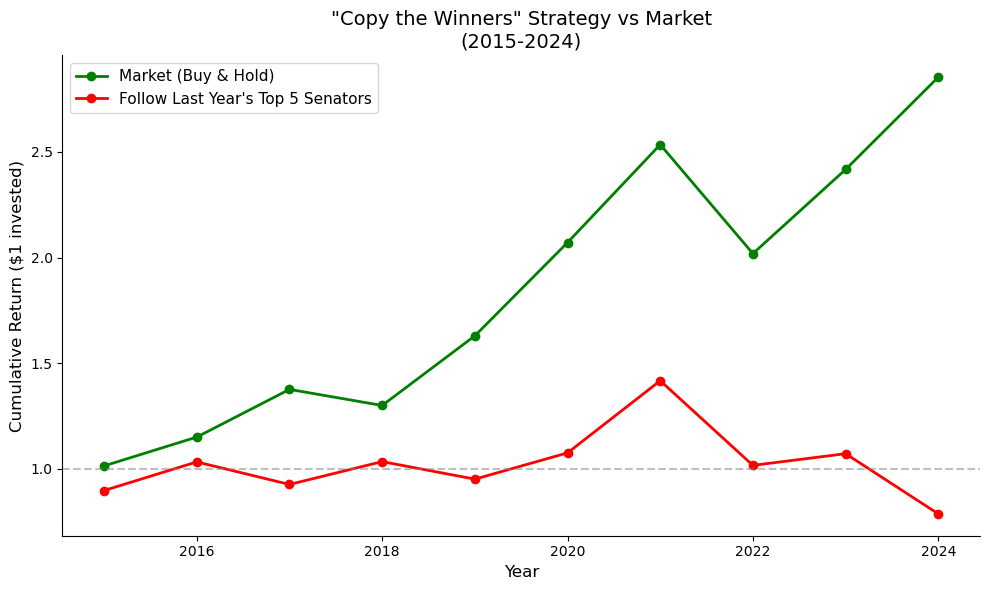

$1 in Market -> $2.85
$1 in Strategy -> $0.79


In [94]:
# Step 45: Clean cumulative chart for "Follow Winners" strategy

strat_df = strat_df.sort_values('year')
strat_df['strat_cum'] = (1 + strat_df['strategy_annual']).cumprod()
strat_df['mkt_cum'] = (1 + strat_df['mktrf']).cumprod()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(strat_df['year'], strat_df['mkt_cum'], marker='o', linewidth=2, color='green', label='Market (Buy & Hold)')
ax.plot(strat_df['year'], strat_df['strat_cum'], marker='o', linewidth=2, color='red', label='Follow Last Year\'s Top 5 Senators')

ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Return ($1 invested)', fontsize=12)
ax.set_title('"Copy the Winners" Strategy vs Market\n(2015-2024)', fontsize=14)
ax.legend(loc='upper left', fontsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('strategy_backtest.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"$1 in Market -> ${strat_df['mkt_cum'].iloc[-1]:.2f}")
print(f"$1 in Strategy -> ${strat_df['strat_cum'].iloc[-1]:.2f}")

### *Section 9 conclusion: Following winners destroys capital*

The strategy returns -0.6% annually vs the market's 12.1%. One dollar invested in the follow-winners strategy in 2015 shrank to 0.79 USD by 2024; the same dollar in the market grew to 2.85 USD. The strategy underperforms in 7 out of 10 years, and the few positive years (2016, 2020, 2021) simply reflect broad market rallies rather than senator-specific skill. Last year's best senators are not next year's best senators — consistent with the near-zero persistence correlation found in Section 6. If there were real, exploitable alpha in senate trades, this strategy would capture it. It does not.

## 10. Why does Quiver show something different? 
Quiver Quantitative's Congress Long-Short strategy reports +363% all-time returns with a 30% CAGR. We reconcile this with our findings by replicating their methodology and identifying what drives the discrepancy. *https://www.quiverquant.com/congresstrading/*
- **Step 46 (sanity check):** Verify our baseline numbers — average 21-day return per trade (0.150%), average market return (1.135%), excess per trade (-0.985%). Purchases-only annualize to 13.6% vs the market's 13.6% — senators' buy trades earn exactly the market return. Average senator makes 455 trades per year.
- **Step 47 (Quiver's period):** Restrict to April 2020 onward — when Quiver's backtest begins. All trades: 3.6% annualized. Purchases only: 26.5% annualized. Market over the same period: 18.1%. Excess return for purchases: +8.4%. The COVID recovery starting point explains most of the gap.
- **Step 48 (rigorous test):** 837 purchase-only trades from April 2020+. The t-test vs market return is marginally significant (t = 2.46, p = 0.014), but the year-by-year breakdown reveals the pattern: senators outperformed in 2020 (+70% vs +40%) and 2021 (+30% vs +22%), then underperformed in 2022 (-30% vs -20%) and recent years.
- **Steps 49-50 (year-by-year chart):** Side-by-side bar chart of senator purchases vs market by year. The 2020 COVID recovery drives Quiver's headline number. In 2022–2024, senators underperform the market in most years.

In [99]:
# Step 46: Sanity check our calculations + Quiver Quant comparison

# Quiver's Congress Long-Short Strategy (from quiverquant.com):
# - Long purchases, short sales (all Congress, not just Senate)
# - Value-weighted by reported transaction size
# - 130% long / 30% short leverage, weekly rebalancing
# - Backtest starts 2020-04-01
# - Reported: +362% all-time, 30% CAGR, alpha 0.07, beta 1.13
# Our closest comparison: direction-adjusted Senate returns and purchases-only from April 2020+

print("=== SANITY CHECK ===\n")

# 1. What's the average per-trade return?
avg_trade = merged['ret_21d_adj'].mean()
print(f"Average 21d return per trade: {avg_trade*100:.3f}%")

# 2. What's the market average 21d return?
avg_mkt_21d = 0.01135
print(f"Average 21d market return: {avg_mkt_21d*100:.3f}%")

# 3. Excess per trade
print(f"Excess per trade: {(avg_trade - avg_mkt_21d)*100:.3f}%")

# 4. How many trades per year on average?
trades_per_year = merged.groupby('year').size().mean()
print(f"\nAverage trades per year (total): {trades_per_year:.0f}")

# 5. Raw returns by direction (not direction-adjusted)
print(f"\nRaw 21d return (purchases only): {merged[merged['Transaction']=='Purchase']['ret_21d'].mean()*100:.3f}%")
print(f"Raw 21d return (sales only): {merged[merged['Transaction']=='Sale']['ret_21d'].mean()*100:.3f}%")

# 6. Purchases only — closest to what drives Quiver's long side
# Note: Quiver uses 130/30 leverage across all Congress, not just Senate
purchases_only = merged[merged['Transaction'] == 'Purchase']
print(f"\nPurchases only (Senate):")
print(f"  Mean 21d return: {purchases_only['ret_21d'].mean()*100:.3f}%")
print(f"  Annualized: {purchases_only['ret_21d'].mean() * (252/21) * 100:.1f}%")
print(f"  Market annualized: {avg_mkt_21d * (252/21) * 100:.1f}%")

=== SANITY CHECK ===

Average 21d return per trade: 0.150%
Average 21d market return: 1.135%
Excess per trade: -0.985%

Average trades per year (total): 455

Raw 21d return (purchases only): 1.131%
Raw 21d return (sales only): 0.792%

Purchases only (Senate):
  Mean 21d return: 1.131%
  Annualized: 13.6%
  Market annualized: 13.6%


In [96]:
# Step 47: Test 2020-04-01 onwards (Quiver's period)

quiver_period = merged[merged['Traded'] >= '2020-04-01']

print(f"Trades from April 2020+: {len(quiver_period)}")
print(f"Date range: {quiver_period['Traded'].min()} to {quiver_period['Traded'].max()}")

# Overall performance
print(f"\n=== QUIVER PERIOD (Apr 2020+) ===")
print(f"Mean 21d return (all trades, adj): {quiver_period['ret_21d_adj'].mean()*100:.3f}%")
print(f"Annualized: {quiver_period['ret_21d_adj'].mean() * (252/21) * 100:.1f}%")

# Purchases only (what Quiver does)
purchases_only = quiver_period[quiver_period['Transaction'] == 'Purchase']
print(f"\n=== PURCHASES ONLY (like Quiver) ===")
print(f"Mean 21d return: {purchases_only['ret_21d'].mean()*100:.3f}%")
print(f"Annualized: {purchases_only['ret_21d'].mean() * (252/21) * 100:.1f}%")

# What did market do Apr 2020+?
ff_quiver = ff[pd.to_datetime(ff['date']) >= '2020-04-01']
mkt_annual = ff_quiver['mktrf'].astype(float).sum() / (len(ff_quiver)/252)
print(f"\n=== MARKET (Apr 2020+) ===")
print(f"Market annual return: {mkt_annual*100:.1f}%")

# Excess
print(f"\n=== EXCESS RETURN ===")
senator_annual = purchases_only['ret_21d'].mean() * (252/21)
print(f"Senator purchases: {senator_annual*100:.1f}%")
print(f"Market: {mkt_annual*100:.1f}%")
print(f"Excess: {(senator_annual - mkt_annual)*100:.1f}%")

Trades from April 2020+: 1917
Date range: 2020-04-01 00:00:00 to 2024-12-27 00:00:00

=== QUIVER PERIOD (Apr 2020+) ===
Mean 21d return (all trades, adj): 0.297%
Annualized: 3.6%

=== PURCHASES ONLY (like Quiver) ===
Mean 21d return: 2.205%
Annualized: 26.5%

=== MARKET (Apr 2020+) ===
Market annual return: 18.1%

=== EXCESS RETURN ===
Senator purchases: 26.5%
Market: 18.1%
Excess: 8.4%


In [100]:
# Step 48: Test purchases-only strategy more rigorously

purchases_quiver = merged[(merged['Traded'] >= '2020-04-01') & (merged['Transaction'] == 'Purchase')].copy()

print("=== PURCHASES ONLY (Apr 2020+) ===")
print(f"N trades: {len(purchases_quiver)}")

# 1. Statistical significance
from scipy import stats
t_stat, p_val = stats.ttest_1samp(purchases_quiver['ret_21d'].dropna(), 0.01135)  # vs market 21d return
print(f"\nt-test vs market return:")
print(f"t-stat: {t_stat:.2f}, p-value: {p_val:.4f}")

# 2. Replication alpha (from filing date) - can you actually capture it?
print(f"\n=== REPLICATION (from filing date) ===")
print(f"Mean return from trade date: {purchases_quiver['ret_21d'].mean()*100:.3f}%")
print(f"Mean return from filing date: {purchases_quiver['ret_21d_replication'].mean()*100:.3f}%")

# 3. Year-by-year - is it consistent or driven by 2020-2021 recovery?
print(f"\n=== YEAR BY YEAR ===")
purchases_quiver['year'] = purchases_quiver['Traded'].dt.year
yearly = purchases_quiver.groupby('year')['ret_21d'].agg(['mean', 'count'])
yearly['annualized'] = yearly['mean'] * (252/21) * 100
print(yearly)

=== PURCHASES ONLY (Apr 2020+) ===
N trades: 837

t-test vs market return:
t-stat: 2.46, p-value: 0.0142

=== REPLICATION (from filing date) ===
Mean return from trade date: 2.205%
Mean return from filing date: 4.807%

=== YEAR BY YEAR ===
          mean  count  annualized
year                             
2020  0.058375    270   70.050422
2021  0.025316    115   30.379576
2022 -0.025012    119  -30.014660
2023  0.006277    246    7.531986
2024  0.013866     86   16.639292


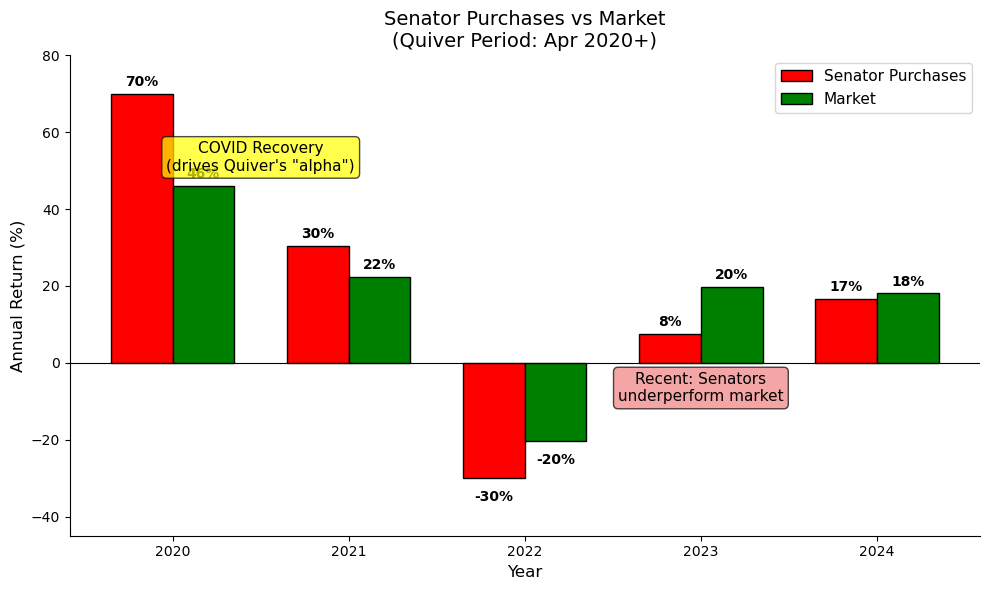

In [98]:
# Step 49: Chart - Senator Purchases vs Market (Year by Year, Apr 2020+)

import matplotlib.pyplot as plt

# Get senator purchases annual returns
purchases_quiver = merged[(merged['Traded'] >= '2020-04-01') & (merged['Transaction'] == 'Purchase')].copy()
purchases_quiver['year'] = purchases_quiver['Traded'].dt.year
senator_yearly = purchases_quiver.groupby('year')['ret_21d'].mean() * (252/21)

# Get market annual returns for same period
ff['year'] = pd.to_datetime(ff['date']).dt.year
market_yearly = ff[pd.to_datetime(ff['date']) >= '2020-04-01'].groupby('year')['mktrf'].sum().astype(float)

# Align years
years = [2020, 2021, 2022, 2023, 2024]
senator_rets = [senator_yearly.get(y, 0) * 100 for y in years]
market_rets = [market_yearly.get(y, 0) * 100 for y in years]

# Plot
# Step 50: Cleaner chart - one color, annotation instead

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(years))
width = 0.35

bars1 = ax.bar(x - width/2, senator_rets, width, label='Senator Purchases', color='red', edgecolor='black')
bars2 = ax.bar(x + width/2, market_rets, width, label='Market', color='green', edgecolor='black')

ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Senator Purchases vs Market\n(Quiver Period: Apr 2020+)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend(loc='upper right', fontsize=11)

# Add value labels
for i, (s, m) in enumerate(zip(senator_rets, market_rets)):
    ax.text(i - width/2, s + 2 if s > 0 else s - 6, f'{s:.0f}%', ha='center', fontsize=10, fontweight='bold')
    ax.text(i + width/2, m + 2 if m > 0 else m - 6, f'{m:.0f}%', ha='center', fontsize=10, fontweight='bold')

# Add annotation for COVID recovery
ax.annotate('COVID Recovery\n(drives Quiver\'s "alpha")', 
            xy=(0.5, 50), fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Add annotation for recent underperformance  
ax.annotate('Recent: Senators\nunderperform market', 
            xy=(3, -10), fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(-45, 80)

plt.tight_layout()
plt.savefig('quiver_period_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### *Section 10 conclusion: Quiver's alpha is a starting-point illusion*

Quiver's backtest begins April 2020 — right after the COVID crash. Anyone buying almost anything at the market bottom earned extraordinary returns. When we replicate their purchases-only approach over the same period, senators do outperform: 26.5% annualized vs the market's 18.1%. But the year-by-year breakdown shows this is entirely driven by 2020 (+70% vs +40%) and 2021 (+30% vs +22%). From 2022 onward, senators underperform in most years. Over our full 2012–2024 sample, purchases-only annualize to 13.6% — exactly equal to the market's 13.6%. Senators' buy trades earn the market return, nothing more.

Quiver's headline 30% CAGR is further inflated by 130/30 leverage — 130% long exposure in a post-COVID bull market mechanically amplifies returns regardless of stock selection. Notably, Quiver's own reported alpha is just 0.07 with a beta of 1.13, confirming that nearly all of the return comes from leveraged market exposure, not skill. Our analysis and Quiver's metrics actually agree: there is no alpha. Starting a backtest at the market bottom is not evidence of alpha — it is evidence of careful chart placement.

## 11. Conclusion

This analysis examines 6,709 disclosed U.S. Senate stock trades from 2012 to 2024, testing whether senators trade on private information and whether the public can profit by copying them.

We find no evidence of either. Calendar-time Fama-French regressions show no insider alpha at any holding period, under both equal and value weighting (Section 4). The COVID event study reveals that a handful of senators — most notably Loeffler — made suspiciously well-timed trades in early 2020, but this does not generalize beyond that episode (Section 5). Senator performance does not persist: the correlation between one year's returns and the next is 0.045, statistically indistinguishable from zero (Section 6). Replication alpha — what a retail investor could actually capture after disclosure — is negative at every lag tested, and a Fama-French regression confirms no alpha after controlling for market, size, and value factors (Section 7). Robustness checks across subsamples, trade sizes, asset types, and outlier senators all confirm the same result: the average senator underperforms the market by roughly 12 percentage points annually (Section 8). A "follow last year's winners" strategy turns one dollar into 0.79 USD while the market turns it into 2.85 USD (Section 9). Quiver Quantitative's headline-grabbing returns are explained entirely by starting their backtest at the April 2020 market bottom (Section 10).

The platforms selling congressional trading data are selling noise dressed up as signal. Senators' disclosed trades contain no exploitable information advantage.

<h3 align="center"><em>In short: the myth was good marketing, but the math did not agree.</em></h3>